# Check Sky Background and zero point units from visit in Auxtel

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-05-07
- last update : 2024-05-15
- affiliation : IJCLab/IN2P3/CNRS

  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/

In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.colors import ListedColormap
from matplotlib import colors

from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time
from datetime import datetime, timedelta
import seaborn as sns

from itertools import cycle, islice
import os

In [2]:
from lsst.daf.butler import Butler

import astropy.units as u
from astropy import constants as const
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom

from astropy.stats import SigmaClip


In [3]:
# INSERT YOUR auxTel/LATISS collection and tract/band HERE
butlerRoot = "/repo/embargo"
#collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240414/w_2024_15/PREOPS-5069' # COMPLETED
collectionn = collection
collections = [collection]
collectionStr = collectionn.replace("/", "_")
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"
tract_sel = 3864
#band = "r"
suptitle = collectionStr + f" inst = {instrument} tract = {tract_sel}"

where_clause = "instrument = \'" + instrument+ "\'"
NDET = 1

fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"

In [4]:
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams["axes.labelsize"] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize']= 'x-large'
plt.rcParams['ytick.labelsize']= 'x-large'
plt.rcParams['legend.fontsize']=  10
plt.rcParams['font.size'] = 12

### Import rubinsimphot
- usefull to check the numbers

In [5]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Set environment for USDF Rubin Science Platform


In [6]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

In [7]:
#from rubinsimphot.phot_utils import PhotometricParameters 
#from rubinsimphot.site_models import SeeingModel
#from rubinsimphot.phot_utils import signaltonoise
#from rubinsimphot.phot_utils import calc_neff

In [8]:
fdir = get_data_dir()
path_rubin_sim_throughput = os.path.join(fdir, 'throughputs', 'auxtel')

In [9]:
import sys
sys.path.append('../lib')

In [10]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections_auxtel import *

LSST site name validated as LSST observatory


### Import atmospheric emulator

In [11]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.1


In [12]:
from getObsAtmo import ObsAtmo
emul_atm = ObsAtmo()

LSST site name validated as LSST observatory


In [13]:
WL = emul_atm.GetWL()

### Import additional functions

In [14]:
def angle_in_range(alpha, lower, upper):
    return (alpha - lower) % 360 <= (upper - lower) % 360

In [15]:
def get_bbox_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    ramin,ramax,decmin,decmax in decimal degrees
    """

    xmin = bbox.beginX
    xmax = bbox.endX
    ymin = bbox.beginY
    ymax = bbox.endY
    
    radec_ll = wcs.pixelToSky(xmin, ymin)
    radec_ur = wcs.pixelToSky(xmax, ymax)
        
    return radec_ur.getRa().asDegrees(),radec_ll.getRa().asDegrees(), radec_ll.getDec().asDegrees(),radec_ur.getDec().asDegrees() 


In [16]:
def isradec_inbbox_radec(ra,dec,wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    Bool
    
    """

    RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(wcs, bbox)

    flag_ra = angle_in_range(ra,RAMIN,RAMAX)
    flag_dec = angle_in_range(dec,DECMIN,DECMAX)

    flag = flag_ra and flag_dec
    return flag


In [17]:
def FindTractAndPatch(row):
    """
    Apply this function on ccdvisitTable dataframe to find the tract and patch for each visit
    """
     
    try:
        ra = row["ra"]
        dec = row["dec"]
        selectFlag = False
        # loop on tract
        for tractID in tractsId_list:
            tractInfo = skymap.generateTract(tractID)
            patches_selected = [patch.getSequentialIndex() for patch in tractInfo]
            wcs=tractInfo.getWcs()
            # loop on patches
            for patch in tractInfo:
                patchID = patch.getSequentialIndex()
                if patchID in patches_selected:
                    ibb=patch.getInnerBBox()
                    flag = isradec_inbbox_radec(ra,dec,wcs, ibb)
                    selectFlag =  selectFlag or flag
                    if selectFlag:
                        return pd.Series([tractID,patchID])
        return pd.Series([0,0])           
                
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,
        return pd.Series([0,0])  
        


## Iteration

## Initiate the butler

In [18]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
print("camera_name = {}".format(camera.getName()))
print("collections = {}".format(collections))

camera_name = LATISS
collections = ['LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240414/w_2024_15/PREOPS-5069']


In [19]:
skymap = butler.get('skyMap', skymap=skymapName, collections=collections)

In [20]:
datasetRefs = butler.registry.queryDatasets(datasetType='ccdVisitTable', collections=collections, where= where_clause)

## tracts and patches

In [21]:
nImage_refs = list(butler.registry.queryDatasets('deepCoadd_nImage'))

In [22]:
tractsId_list = np.unique([ref.dataId['tract'] for ref in nImage_refs])
tractsId_list = sorted(tractsId_list)
print(tractsId_list)

[3863, 3864, 5615, 5634]


In [23]:
ccd_visit_table = butler.get('ccdVisitTable', dataId={'instrument': instrument}, collections = collections )    

In [24]:
ccd_visit_table["ccdVid"] = ccd_visit_table.index -  ccd_visit_table.index[0]
ccd_visit_table["Vid"] = ccd_visit_table["visitId"]  -   ccd_visit_table["visitId"].iloc[0]

In [25]:
#subtract the a bug number to have normal dates
ccd_visit_table["nightObs"] = ccd_visit_table.apply(lambda x: x['visitId']//100_000, axis=1)
ccd_visit_table["nightObs"]

ccdVisitId
40919696896    20230511
40919697408    20230511
40919698432    20230511
40919698944    20230511
40919699200    20230511
                 ...   
43729938688    20240410
43729938944    20240410
43729939200    20240410
43729939456    20240410
43729939712    20240410
Name: nightObs, Length: 5397, dtype: int64

In [26]:
# get time
ccd_visit_table["Time"] = pd.to_datetime(ccd_visit_table['obsStart'])

In [27]:
# get airmass
ccd_visit_table["airmass"] = ccd_visit_table["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))

In [28]:
#ccd_visit_table_subset = ccd_visit_table[["ra","dec"]].iloc[:10]
#ccd_visit_table_subset[["tractID","patchID"]] =  ccd_visit_table_subset.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [29]:
# to speed up the calculation of tractID, patchID per visit, this file is saved
# or read back
if os.path.isfile(fn_ccdVisit_tracts_patches):
    print(f"{fn_ccdVisit_tracts_patches} found !!! ==> Read it !!!" )
    ccd_visit_tract_patch_table = pd.read_csv(fn_ccdVisit_tracts_patches) 
    ccd_visit_tract_patch_table.set_index("ccdVisitId",inplace=True)
    ccd_visit_tract_patch_table_only = ccd_visit_tract_patch_table[["tractID","patchID"]]
    ccd_visit_table = ccd_visit_table.join(ccd_visit_tract_patch_table_only)
else:
    print(f"{fn_ccdVisit_tracts_patches} NOT found !!! ==> Create it !!! " )
    ccd_visit_table[["tractID","patchID"]] = ccd_visit_table.apply(FindTractAndPatch, axis=1,result_type ='expand')
    columns_selected = ["ra","dec","llcra","llcdec","ulcra","ulcdec","urcra","urcdec","lrcra","lrcdec","ccdVid","Vid","nightObs","tractID","patchID","zeroPoint","airmass","skyBg","skyNoise","expTime"]
    ccd_visit_tract_patch_table = ccd_visit_table[columns_selected]
    ccd_visit_table_saved.to_csv(fn_ccdVisit_tracts_patches) 

ccdVisittractpatch_LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069.csv found !!! ==> Read it !!!


In [30]:
#ccd_visit_table[["tractID","patchID"]] = ccd_visit_table.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [31]:
ccd_visit_table

visitId   physical_filter band          ra        dec  \
ccdVisitId                                                                 
40919696896  2023051100262  SDSSr_65mm~empty    r  239.946728 -24.053747   
40919697408  2023051100264  SDSSi_65mm~empty    i  239.938164 -24.036848   
40919698432  2023051100268  SDSSr_65mm~empty    r  239.964414 -24.045512   
40919698944  2023051100270  SDSSi_65mm~empty    i  239.961137 -24.046364   
40919699200  2023051100271  SDSSi_65mm~empty    i  239.977384 -24.051453   
...                    ...               ...  ...         ...        ...   
43729938688  2024041000489  empty~SDSSy_65mm    y  122.551050 -36.170491   
43729938944  2024041000490  SDSSg_65mm~empty    g  122.568634 -36.170416   
43729939200  2024041000491  SDSSr_65mm~empty    r  122.568863 -36.170458   
43729939456  2024041000492  SDSSz_65mm~empty    z  122.569102 -36.170522   
43729939712  2024041000493  empty~SDSSy_65mm    y  122.569469 -36.170520   

             zenithDistance  zeroPoint  psfSigma      skyBg  skyNoise  \
ccdVisitId                                                              
40919696896       56.749516  27.691925  7.762391  11.193549  7.856800   
40919697408       55.439133  27.854723  6.322155  28.073927  8.586373   
40919698432       54.482189  27.773005  8.037395  10.700970  7.854424   
40919698944       53.849274  27.859426  6.755349  23.952974  8.440454   
40919699200       53.394787  27.846539  6.483695  23.321407  8.416399   
...                     ...        ...       ...        ...       ...   
43729938688       48.575981  26.041475  3.027215  15.985236  8.106778   
43729938944       48.890800  27.940567  7.590302   3.106054  7.474746   
43729939200       49.044880  27.792534  6.214056   6.620466  7.680325   
43729939456       49.199879  27.290150  5.768389  18.576742  8.271068   
43729939712       49.359600  26.105070  5.690092  16.031017  8.091838   

             astromOffsetMean  astromOffsetStd  nPsfStar  \
ccdVisitId                                                 
40919696896          0.025776         0.014186        27   
40919697408          0.026761         0.017073        38   
40919698432          0.024561         0.014016        13   
40919698944          0.023946         0.012757        22   
40919699200          0.028203         0.012467        30   
...                       ...              ...       ...   
43729938688          0.016824         0.008926        17   
43729938944          0.023803         0.013601        24   
43729939200          0.017627         0.010458        63   
43729939456          0.017991         0.009512        73   
43729939712          0.019387         0.009520        54   

             psfStarDeltaE1Median  psfStarDeltaE2Median  \
ccdVisitId                                                
40919696896             -0.001745             -0.001060   
40919697408              0.004663             -0.011849   
40919698432              0.001861             -0.007651   
40919698944             -0.002761              0.003552   
40919699200             -0.001598              0.001411   
...                           ...                   ...   
43729938688             -0.010616              0.004564   
43729938944             -0.001470             -0.011347   
43729939200              0.003413             -0.002496   
43729939456              0.002246             -0.000265   
43729939712             -0.005097              0.001315   

             psfStarDeltaE1Scatter  psfStarDeltaE2Scatter  \
ccdVisitId                                                  
40919696896               0.027277               0.009195   
40919697408               0.035530               0.031318   
40919698432               0.011237               0.003619   
40919698944               0.032406               0.019224   
40919699200               0.026768               0.013537   
...                            ...                    ...   
43729938688               0.038183         

In [32]:
# number of elapsed days
ccd_visit_table["daynum"] = ccd_visit_table["expMidptMJD"]-ccd_visit_table["expMidptMJD"].min()

In [33]:
ccd_visit_table["log_skyBg"] = 2.5*np.log10(ccd_visit_table["skyBg"])

## Configuration

In [34]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/home/d/dagoret/repos/repos_w_2024_17/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


Text(0.5, 1.0, 'Instrument throughput')

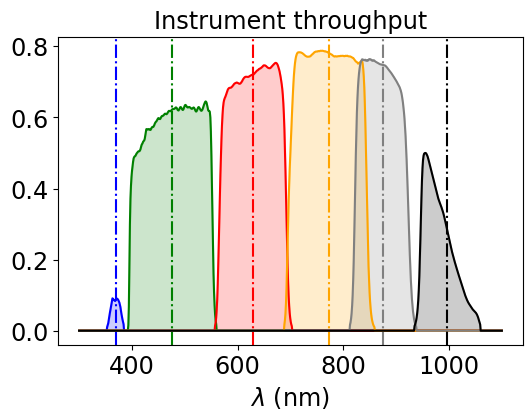

In [35]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument throughput")

In [36]:
all_Sigb = {}

for index,f in enumerate(filter_tagnames): 
    wl = pc.bandpass_inst[f].wavelen
    tr = pc.bandpass_inst[f].sb
    Sigb = np.trapz(tr/wl,wl)
    all_Sigb[f] = Sigb 

In [37]:
pd.DataFrame(all_Sigb, index=['Sigmab']).round(4)

u       g       r       i      z     y
Sigmab  0.0055  0.1961  0.1434  0.1481  0.085  0.03

Text(0.5, 1.0, 'Standard atmosphere transmission')

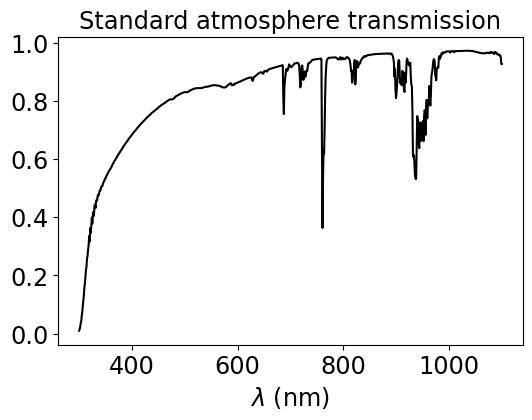

In [38]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

Text(0.5, 1.0, 'Total filter throughput')

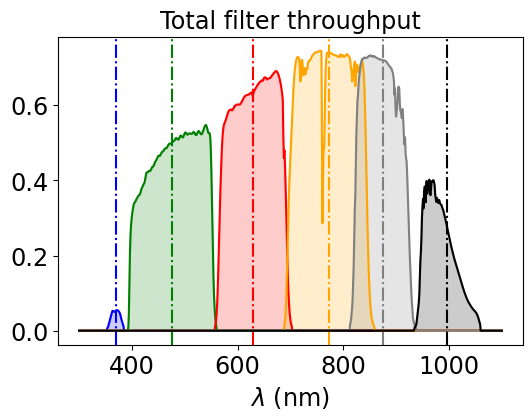

In [39]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames): 
    axs.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total filter throughput")

## Zero point

- https://github.com/sylvielsstfr/rubinsimphot/blob/main/src/rubinsimphot/phot_utils/bandpass.py

In [40]:
# Need to select an exposure of 1 second as the zero-point refers to a flux of 1 ADU/sec
photoparams._exptime = 30.0
pprint(vars(photoparams))

{'_bandpass': None,
 '_darkcurrent': 0.2,
 '_effarea': 9636.0,
 '_exptime': 30.0,
 '_gain': 1.3,
 '_nexp': 1,
 '_othernoise': 0.0,
 '_platescale': 0.1,
 '_readnoise': 8.96875,
 '_sigma_sys': 0.005}


In [41]:
# Calculate the standard dark sky zenith magnitudes - for reference
zeropoint_mags = {}

for index,f in enumerate(filter_tagnames):
   
    zp = pc.bandpass_total_std[f].calc_zp_t(photoparams)
    zeropoint_mags[f] = zp
    
pd.DataFrame(zeropoint_mags, index=['ZP (mag)']).round(2)

u      g      r      i      z      y
ZP (mag)  24.01  28.19  27.97  28.05  27.47  26.27

## Calculation on Dark Sky

In [42]:
path_rubin_sim_throughput=os.path.join(get_data_dir(),"throughputs/baseline")

In [43]:
darksky = Sed()
darksky.read_sed_flambda(os.path.join(path_rubin_sim_throughput, 'darksky.dat'))

In [44]:
index_sel = np.where(np.logical_and(darksky.wavelen>=WLMIN,darksky.wavelen<WLMAX))[0]
wav = darksky.wavelen[index_sel]
fll = darksky.flambda[index_sel]
darksel = Sed(wavelen=wav, flambda=fll)

Text(0, 0.5, '$F_\\nu (\\lambda)$ (Jy/as2)')

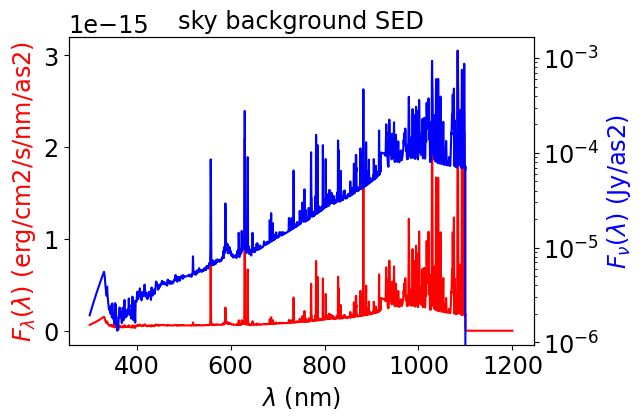

In [45]:
fig, ax1 = plt.subplots(1,1,figsize=(6,4))
ax1.plot(darksky.wavelen,darksky.flambda,'r-',label="$F_\lambda (\lambda)$")
#axs.plot(darksel.wavelen,darksel.flambda,'b-')
ax1.set_title("sky background SED")
ax1.set_xlabel("$\\lambda$ (nm)")
ax1.set_ylabel("$F_\lambda (\lambda)$ (erg/cm2/s/nm/as2)",color="r")
ax2 = ax1.twinx()
wl,fnu = darksky.get_sed_fnu()
ax2.plot(wl,fnu,"b-",label="$F_\\nu (\lambda)$")
ax2.set_yscale("log")
ax2.set_ylabel("$F_\\nu (\lambda)$ (Jy/as2)",color="b")

### Compute magnitudes
- https://github.com/sylvielsstfr/rubinsimphot/blob/main/src/rubinsimphot/phot_utils/sed.py

In [46]:
# Calculate the standard dark sky zenith magnitudes - for reference
darksky_mags = {}

for index,f in enumerate(filter_tagnames):
    
    band_wl = pc.bandpass_inst[f].wavelen
    band_tr = pc.bandpass_inst[f].sb
    darksky_mags[f] = darksky.calc_mag(pc.bandpass_inst[f])
    
pd.DataFrame(darksky_mags, index=['Dark sky magnitudes/as2']).round(2)

u      g      r      i      z      y
Dark sky magnitudes/as2  23.16  22.28  21.18  20.34  19.56  18.57

### Check the instrument

#### Photometric parameters

**Compute ADU**
- https://github.com/sylvielsstfr/rubinsimphot/blob/main/src/rubinsimphot/phot_utils/sed.py

In [47]:
#surface : in cm2
# exposure time : in sec
# gain : electrons per ADU
# Cb = C \int Fnu S dwl/wl
# C = (pi*D^2/(4gh))* Dt = S/(gh)* Dt

photoparams._exptime = 1. 
from pprint import pprint
pprint(vars(photoparams))

{'_bandpass': None,
 '_darkcurrent': 0.2,
 '_effarea': 9636.0,
 '_exptime': 1.0,
 '_gain': 1.3,
 '_nexp': 1,
 '_othernoise': 0.0,
 '_platescale': 0.1,
 '_readnoise': 8.96875,
 '_sigma_sys': 0.005}


In [48]:
# Calculate the standard dark sky zenith magnitudes - for reference
darksky_adu = {}

for index,f in enumerate(filter_tagnames):
    
    band_wl = pc.bandpass_inst[f].wavelen
    band_tr = pc.bandpass_inst[f].sb
    darksky_adu[f] = darksky.calc_adu(pc.bandpass_inst[f],photoparams)*pixel_scale**2
    
pd.DataFrame(darksky_adu, index=['Dark sky adu/pix/s']).round(2)

u    g    r     i     z     y
Dark sky adu/pix/s  0.0  0.1  0.2  0.44  0.52  0.46

In [49]:
# Calculate the standard dark sky zenith magnitudes - for reference
#photoparams = set_photometric_parameters(30, 1 , readnoise=None)
photoparams._exptime = 30.

darksky_adu = {}

for index,f in enumerate(filter_tagnames):
    
    band_wl = pc.bandpass_inst[f].wavelen
    band_tr = pc.bandpass_inst[f].sb
    darksky_adu[f] = darksky.calc_adu(pc.bandpass_inst[f],photoparams)*pixel_scale**2
    
pd.DataFrame(darksky_adu, index=['Dark sky adu/expo']).round(2)

u     g    r      i      z     y
Dark sky adu/expo  0.04  2.93  5.9  13.15  15.57  13.7

### Calculate the background magnitude

In [50]:
ccd_visit_table["mb"] = ccd_visit_table[["band","skyBg","expTime"]].apply(lambda x: funcBbtomb(x["skyBg"],x["expTime"],all_Sigb[x["band"]]),axis=1)
#ccd_visit_table["mb"] = ccd_visit_table[["band","skyBg","expTime"]].apply(lambda x: all_Sigb[x["band"]],axis=1)

In [51]:
ccd_visit_table["mb"] 

ccdVisitId
40919696896    20.488143
40919697408    19.524877
40919698432    20.537004
40919698944    19.697236
40919699200    19.726248
                 ...    
43729938688    18.403798
43729938944    22.219703
43729939200    21.058341
43729939456    19.370613
43729939712    18.400693
Name: mb, Length: 5397, dtype: float64

In [52]:
ccd_visit_table_g = ccd_visit_table[ccd_visit_table["band"] == 'g']
ccd_visit_table_r = ccd_visit_table[ccd_visit_table["band"] == 'r']
ccd_visit_table_i = ccd_visit_table[ccd_visit_table["band"] == 'i']
ccd_visit_table_z = ccd_visit_table[ccd_visit_table["band"] == 'z']
ccd_visit_table_y = ccd_visit_table[ccd_visit_table["band"] == 'y']

## Sky Background

### Sky Background in g band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

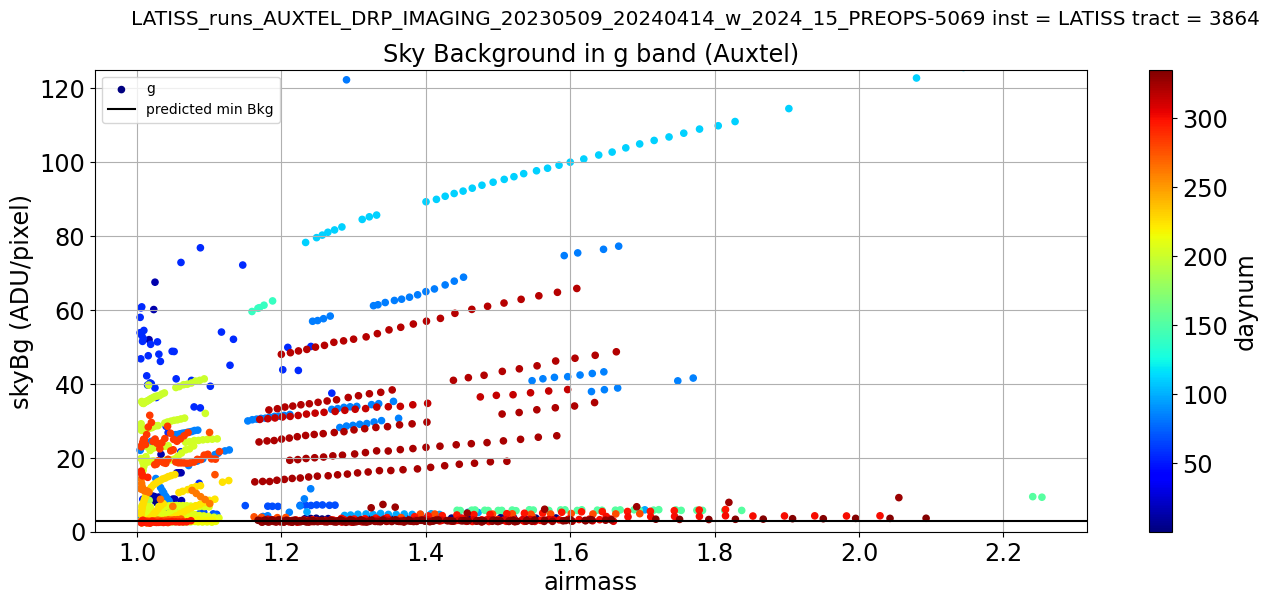

In [53]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=True)
title = "Sky Background in g band (Auxtel)"
ccd_visit_table_g.plot.scatter(x="airmass",y="skyBg",marker="o",ax=ax,c="daynum",cmap="jet",grid=True,label="g",ylabel="skyBg (ADU/pixel)")
ax.set_ylim(0.,125)
ax.set_title(title)
ax.axhline(darksky_adu["g"],c='k',label="predicted min Bkg")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

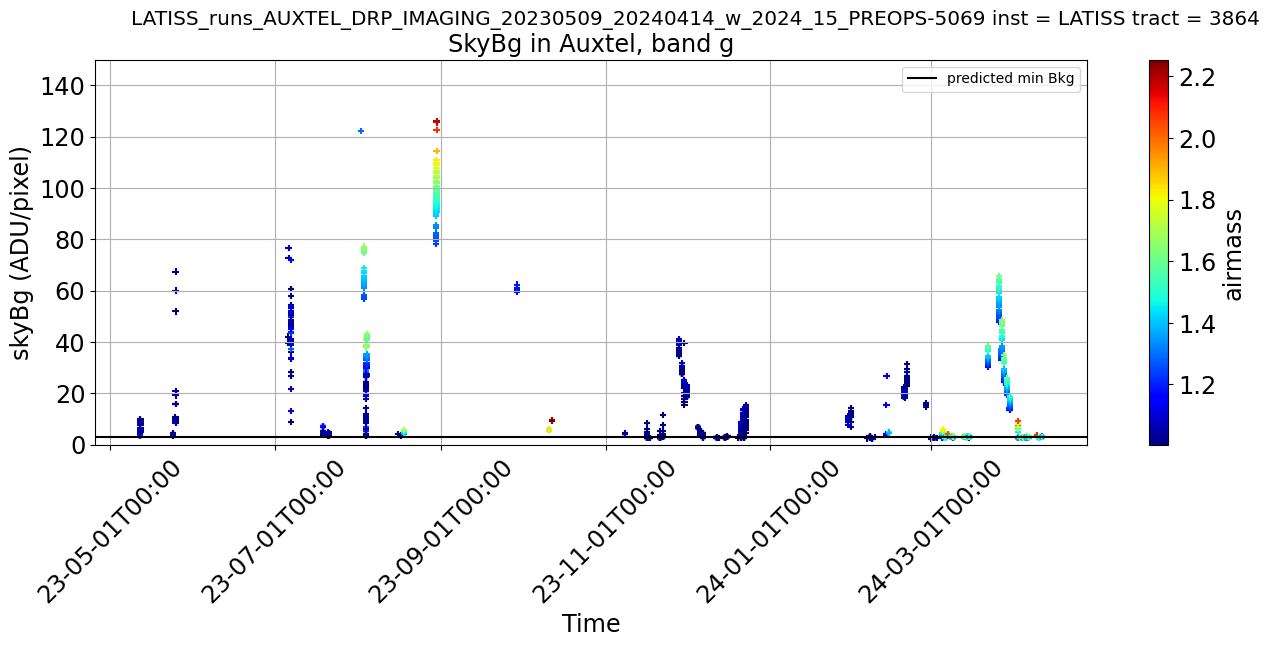

In [54]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"SkyBg in Auxtel, band g"
ccd_visit_table_g.plot.scatter(x="Time",y="skyBg",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="skyBg (ADU/pixel)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(0.,150)
ax.axhline(darksky_adu["g"],c='k',label="predicted min Bkg")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

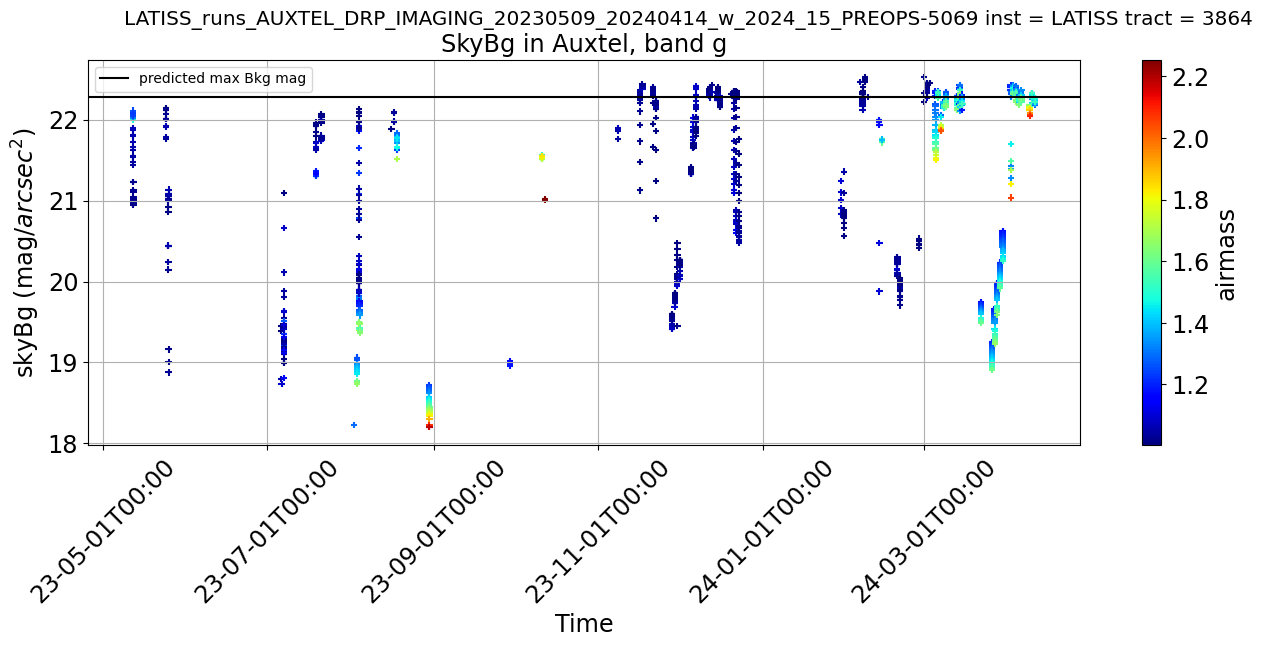

In [55]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"SkyBg in Auxtel, band g"
ccd_visit_table_g.plot.scatter(x="Time",y="mb",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="skyBg (mag/$arcsec^2$)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
#ax.set_ylim(0.,150)
ax.axhline(darksky_mags["g"],c='k',label="predicted max Bkg mag")
ax.legend()
plt.suptitle(suptitle)

### Sky Background in r band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

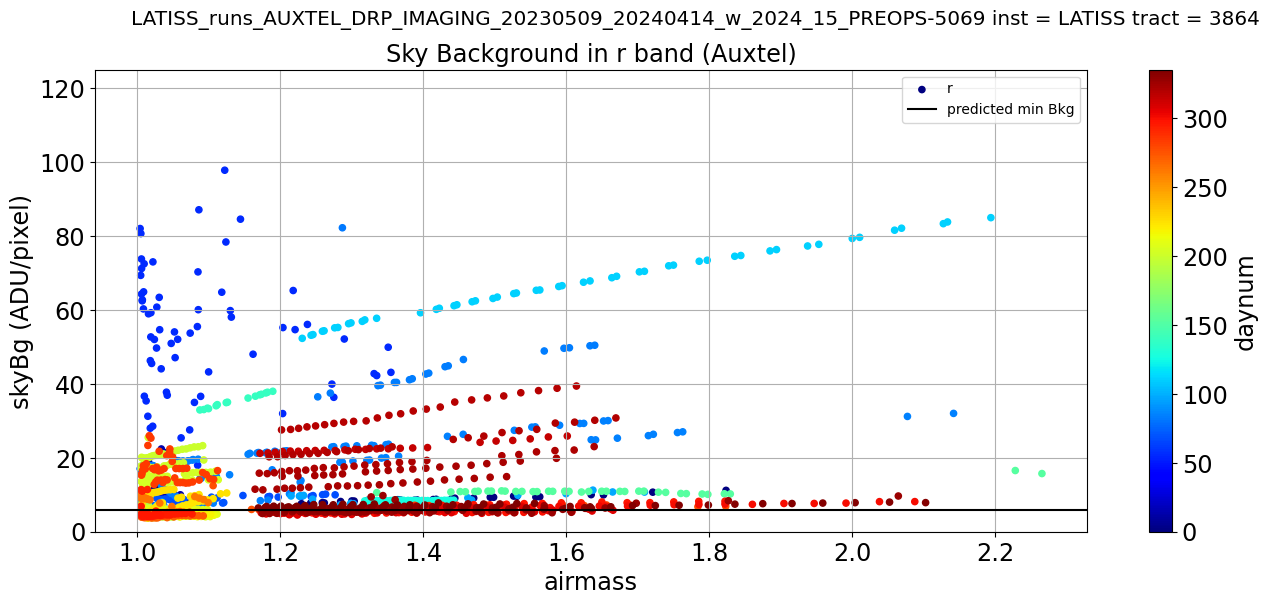

In [56]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=True)
title = "Sky Background in r band (Auxtel)"
ccd_visit_table_r.plot.scatter(x="airmass",y="skyBg",marker="o",ax=ax,c="daynum",cmap="jet",grid=True,label="r",ylabel="skyBg (ADU/pixel)")
ax.set_ylim(0.,125)
ax.set_title(title)
ax.axhline(darksky_adu["r"],c='k',label="predicted min Bkg")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

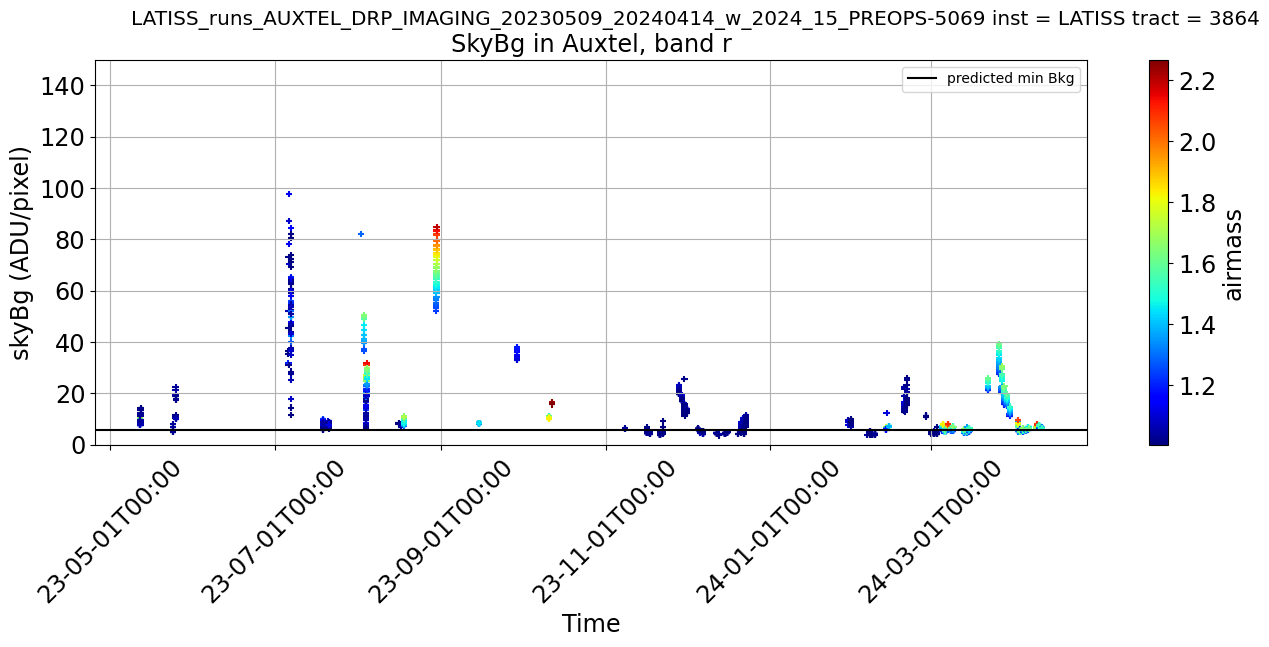

In [57]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"SkyBg in Auxtel, band r"
ccd_visit_table_r.plot.scatter(x="Time",y="skyBg",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="skyBg (ADU/pixel)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(0.,150)
ax.axhline(darksky_adu["r"],c='k',label="predicted min Bkg")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

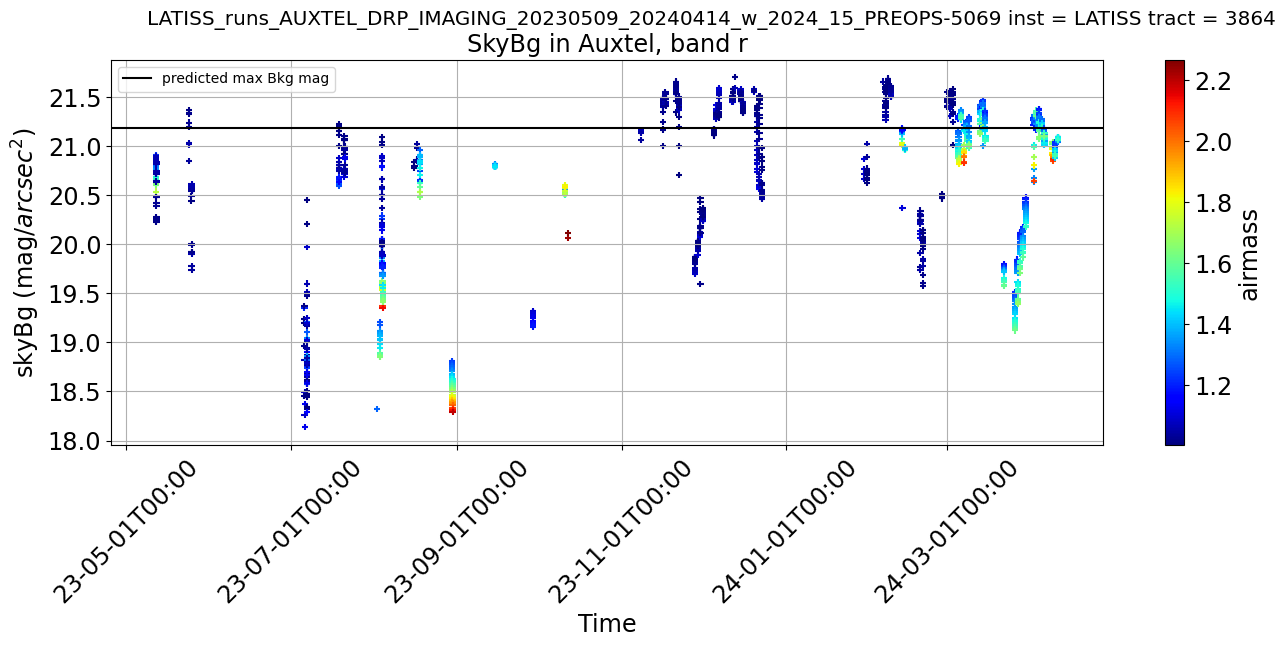

In [58]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"SkyBg in Auxtel, band r"
ccd_visit_table_r.plot.scatter(x="Time",y="mb",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="skyBg (mag/$arcsec^2$)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
#ax.set_ylim(0.,150)
ax.axhline(darksky_mags["r"],c='k',label="predicted max Bkg mag")
ax.legend()
plt.suptitle(suptitle)

### Sky Background in i band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

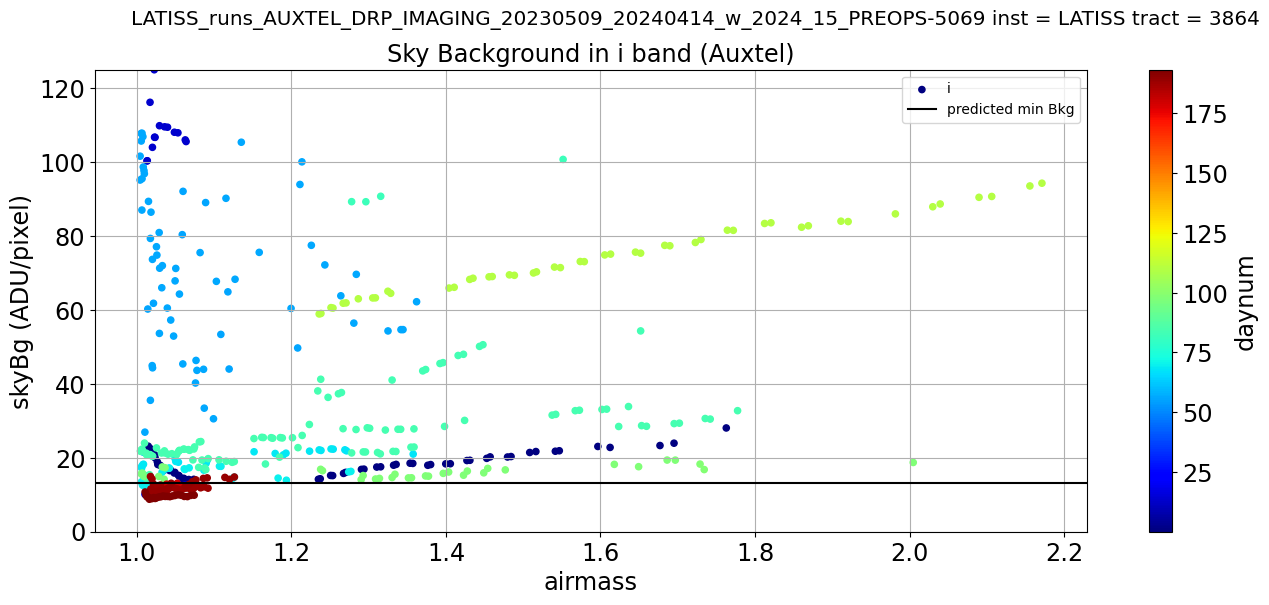

In [59]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=True)
title = "Sky Background in i band (Auxtel)"
ccd_visit_table_i.plot.scatter(x="airmass",y="skyBg",marker="o",ax=ax,c="daynum",cmap="jet",grid=True,label="i",ylabel="skyBg (ADU/pixel)")
ax.set_ylim(0.,125)
ax.set_title(title)
ax.axhline(darksky_adu["i"],c='k',label="predicted min Bkg")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

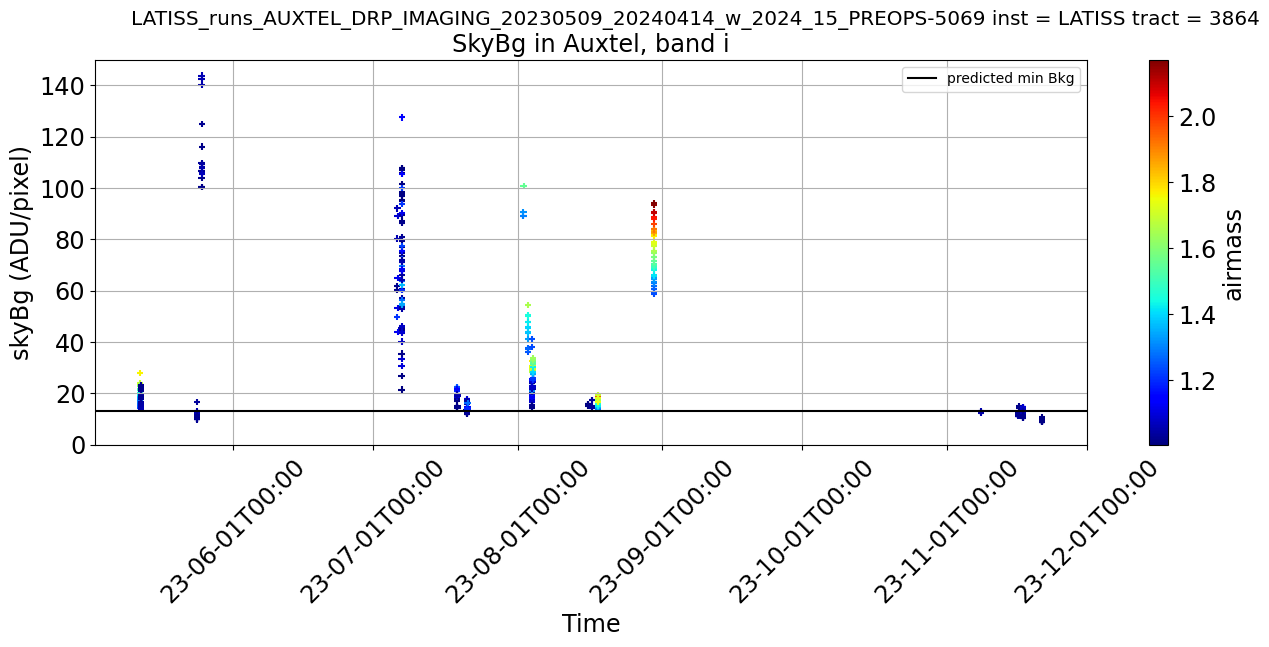

In [60]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"SkyBg in Auxtel, band i"
ccd_visit_table_i.plot.scatter(x="Time",y="skyBg",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="skyBg (ADU/pixel)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(0.,150)
ax.axhline(darksky_adu["i"],c='k',label="predicted min Bkg")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

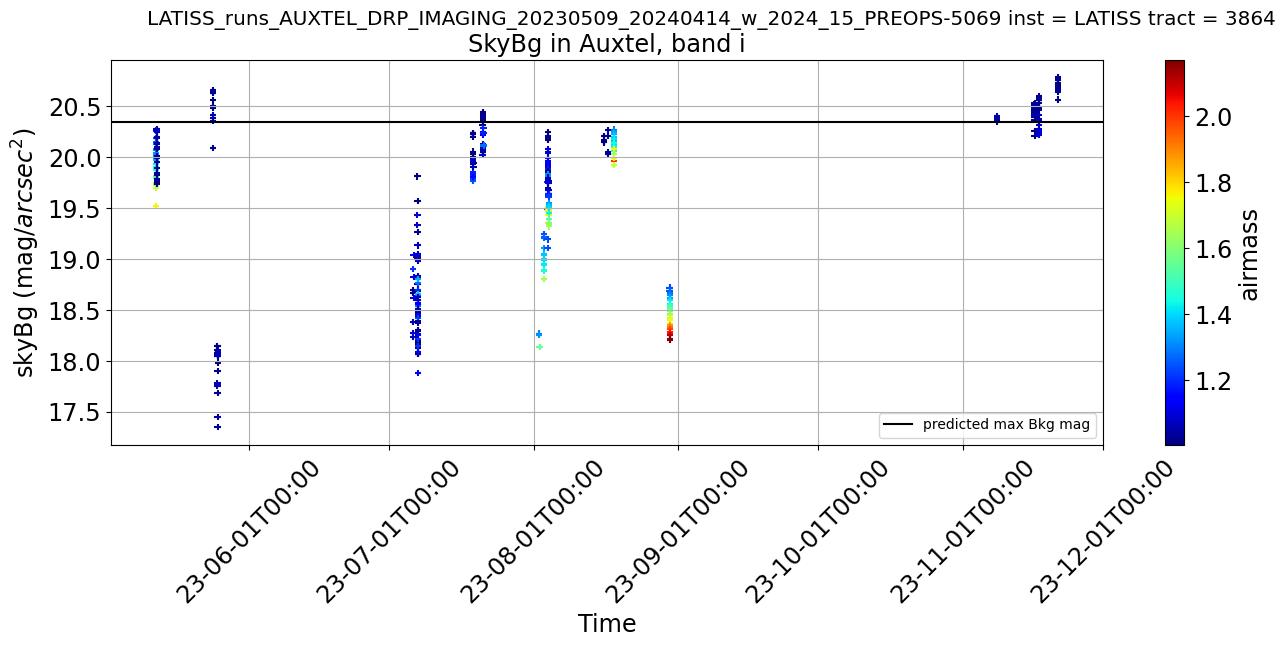

In [61]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"SkyBg in Auxtel, band i"
ccd_visit_table_i.plot.scatter(x="Time",y="mb",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="skyBg (mag/$arcsec^2$)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
#ax.set_ylim(0.,150)
ax.axhline(darksky_mags["i"],c='k',label="predicted max Bkg mag")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

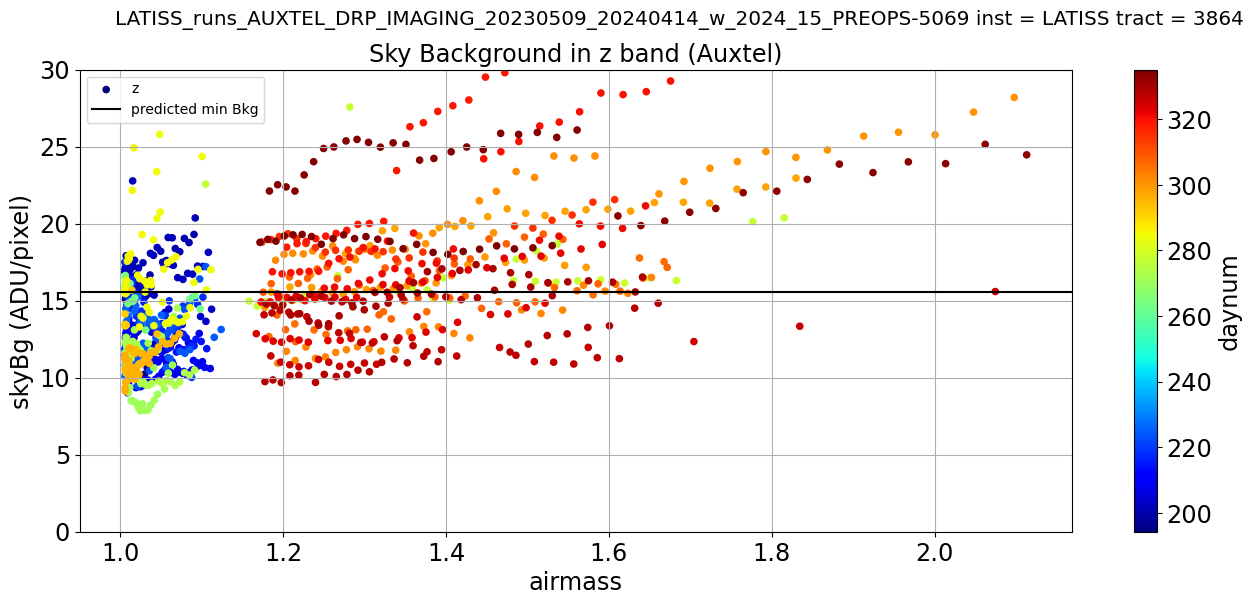

In [62]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=True)
title = "Sky Background in z band (Auxtel)"
ccd_visit_table_z.plot.scatter(x="airmass",y="skyBg",marker="o",ax=ax,c="daynum",cmap="jet",grid=True,label="z",ylabel="skyBg (ADU/pixel)")
ax.set_ylim(0.,30)
ax.set_title(title)
ax.axhline(darksky_adu["z"],c='k',label="predicted min Bkg")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

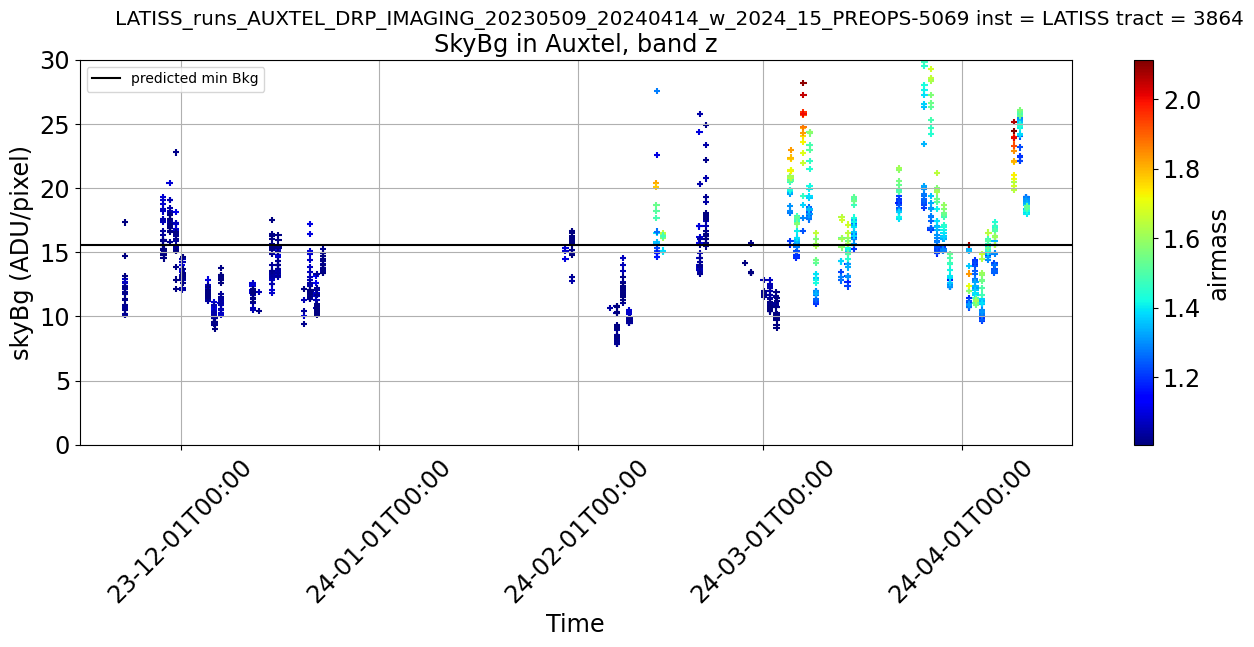

In [63]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"SkyBg in Auxtel, band z"
ccd_visit_table_z.plot.scatter(x="Time",y="skyBg",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="skyBg (ADU/pixel)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(0.,30)
ax.axhline(darksky_adu["z"],c='k',label="predicted min Bkg")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

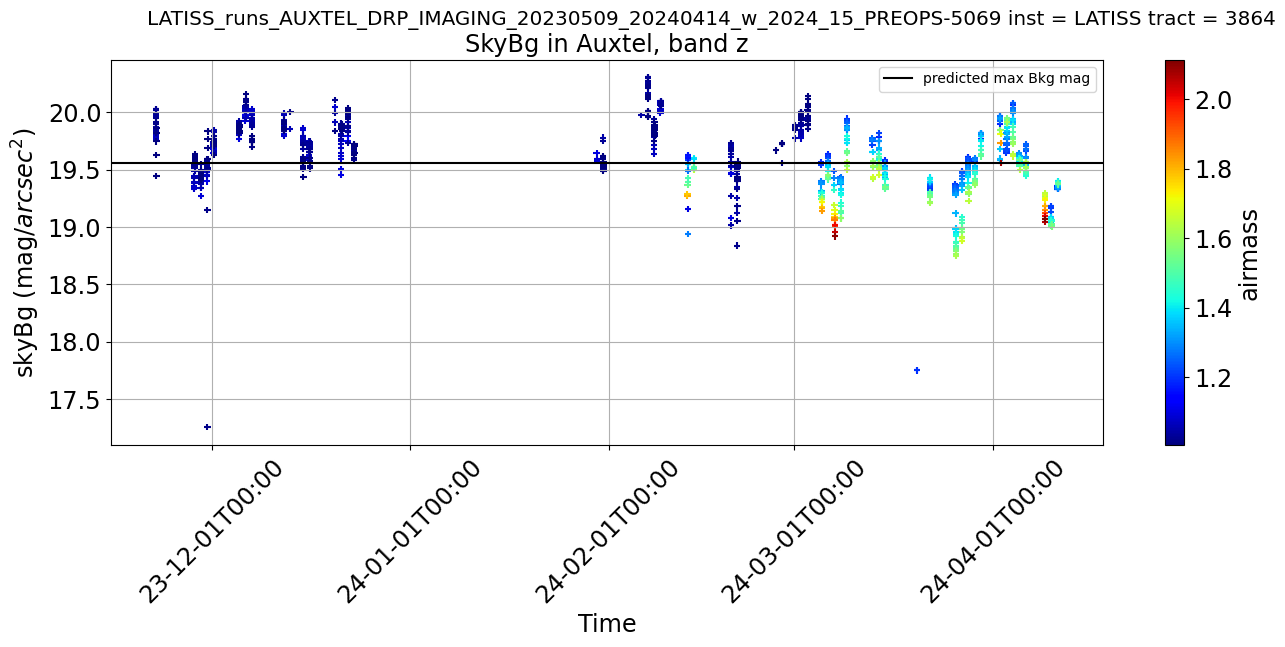

In [64]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"SkyBg in Auxtel, band z"
ccd_visit_table_z.plot.scatter(x="Time",y="mb",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="skyBg (mag/$arcsec^2$)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
#ax.set_ylim(0.,150)
ax.axhline(darksky_mags["z"],c='k',label="predicted max Bkg mag")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

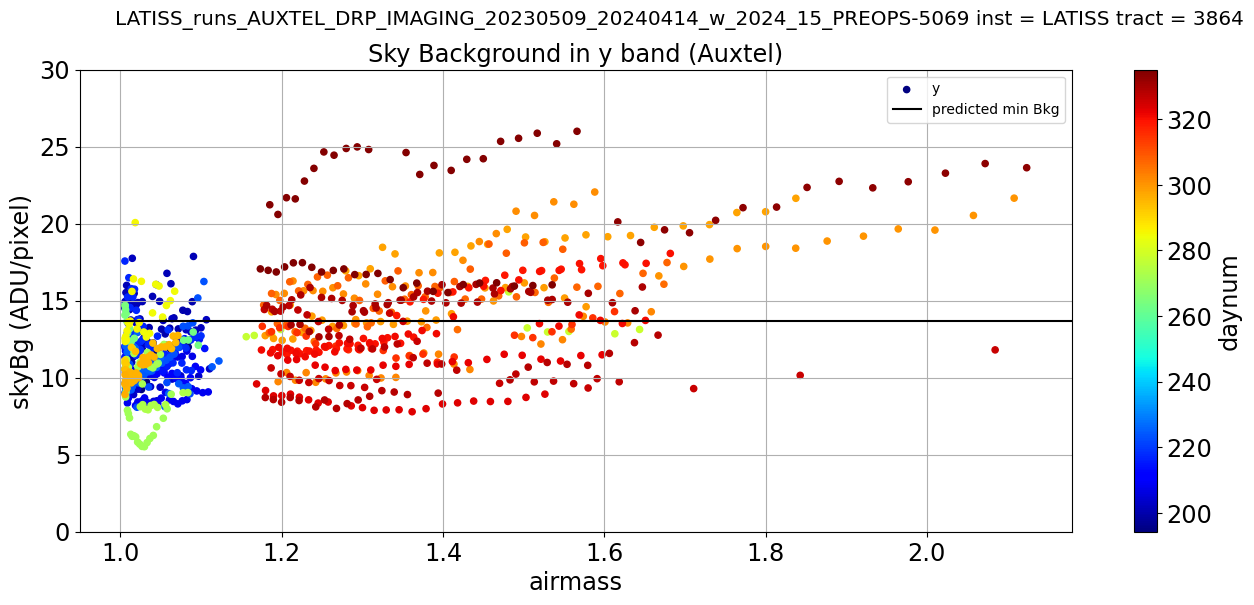

In [65]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=True)
title = "Sky Background in y band (Auxtel)"
ccd_visit_table_y.plot.scatter(x="airmass",y="skyBg",marker="o",ax=ax,c="daynum",cmap="jet",grid=True,label="y",ylabel="skyBg (ADU/pixel)")
ax.set_ylim(0.,30)
ax.set_title(title)
ax.axhline(darksky_adu["y"],c='k',label="predicted min Bkg")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

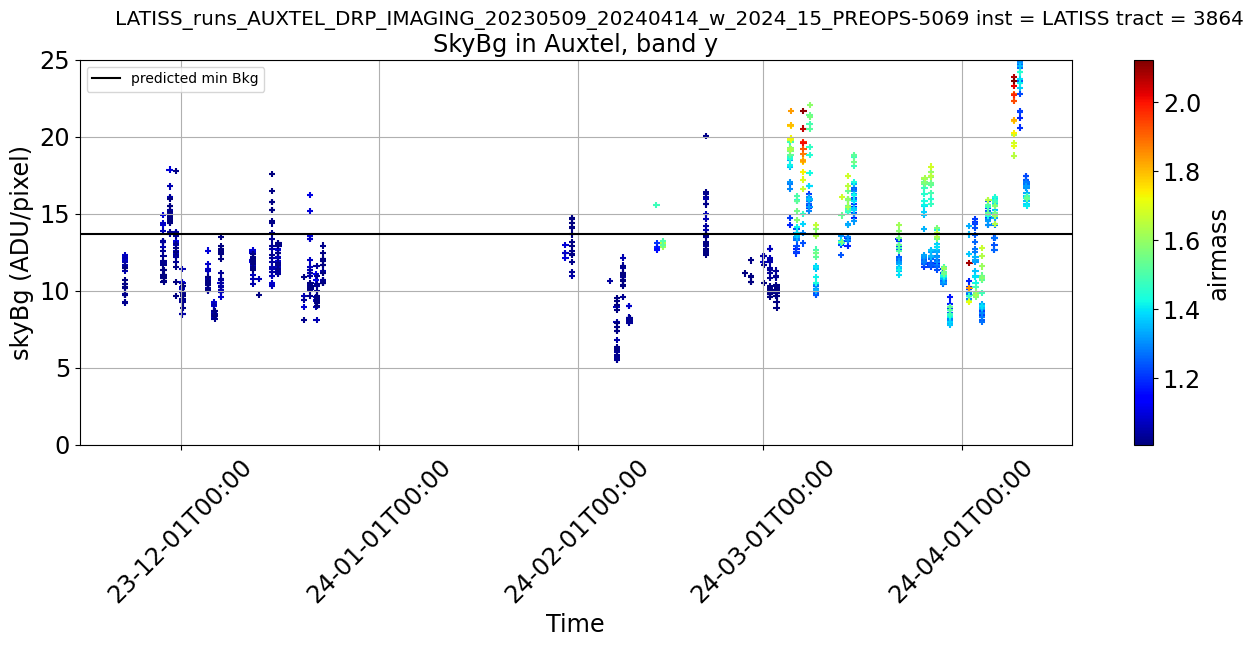

In [66]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"SkyBg in Auxtel, band y"
ccd_visit_table_y.plot.scatter(x="Time",y="skyBg",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="skyBg (ADU/pixel)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(0.,25)
ax.axhline(darksky_adu["y"],c='k',label="predicted min Bkg")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

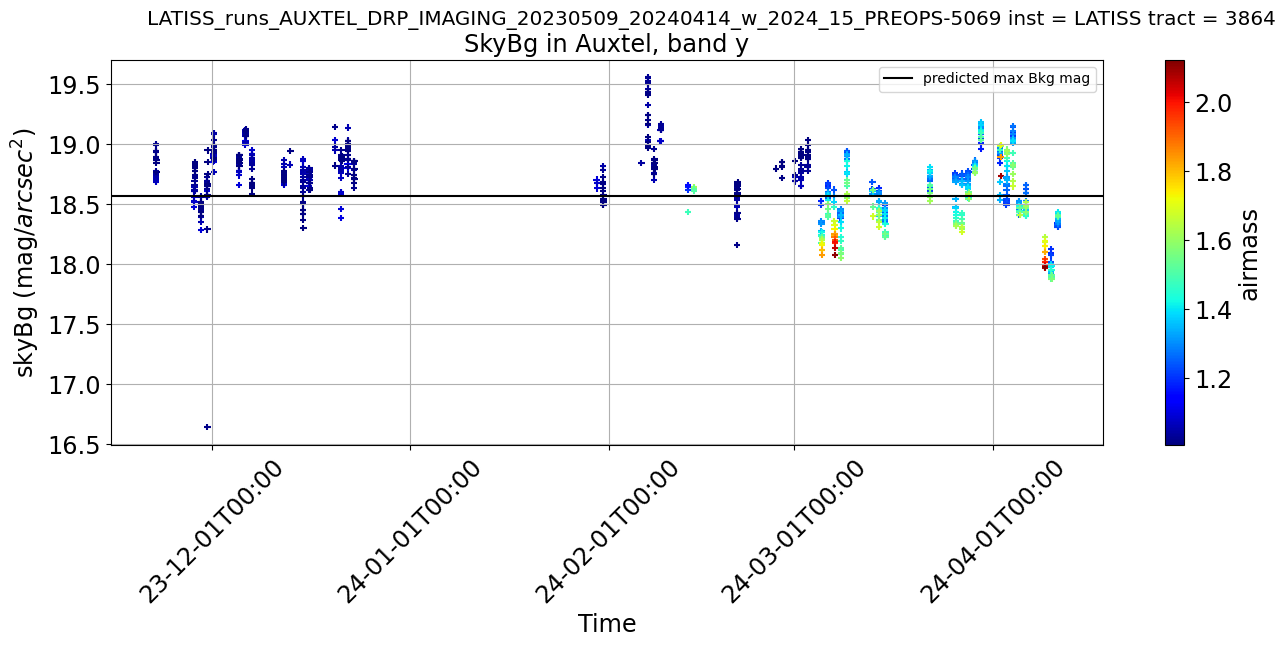

In [67]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = f"SkyBg in Auxtel, band y"
ccd_visit_table_y.plot.scatter(x="Time",y="mb",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="skyBg (mag/$arcsec^2$)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
#ax.set_ylim(0.,150)
ax.axhline(darksky_mags["y"],c='k',label="predicted max Bkg mag")
ax.legend()
plt.suptitle(suptitle)

## Zero-Point

### Zero Point in g band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

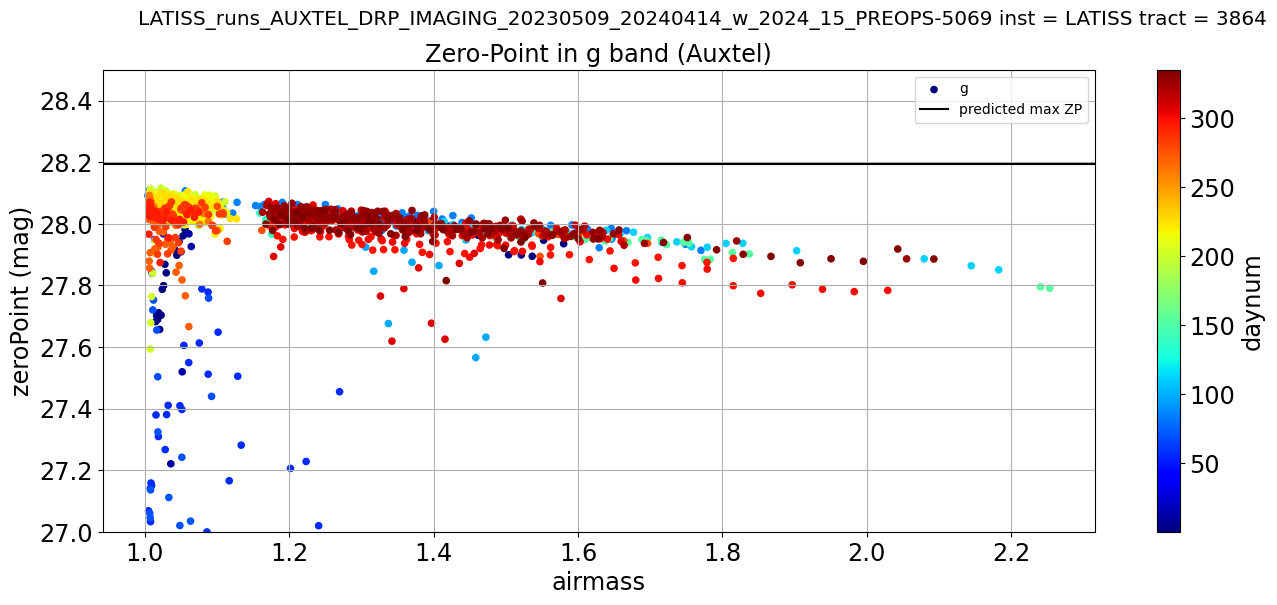

In [68]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=True)
title = "Zero-Point in g band (Auxtel)"
ccd_visit_table_g.plot.scatter(x="airmass",y="zeroPoint",marker="o",ax=ax,c="daynum",cmap="jet",grid=True,label="g",ylabel="zeroPoint (mag)")
ax.set_ylim(27.,28.5)
ax.set_title(title)
ax.axhline(zeropoint_mags["g"],c='k',label="predicted max ZP")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

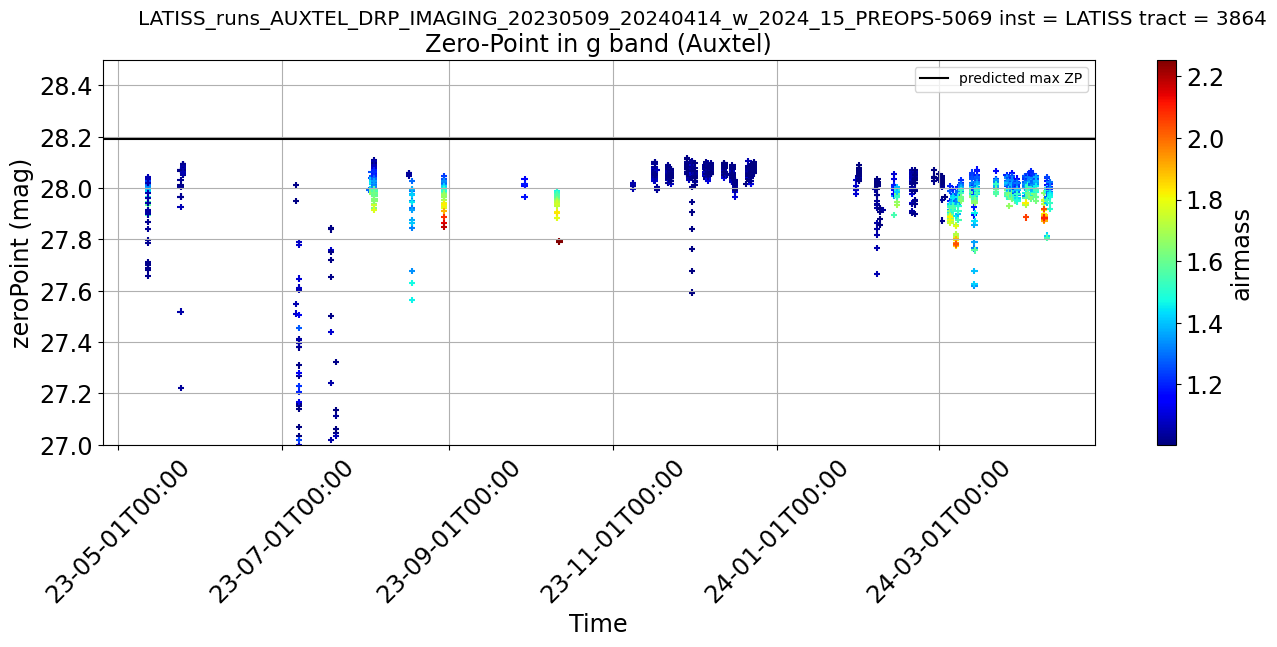

In [69]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = "Zero-Point in g band (Auxtel)"
ccd_visit_table_g.plot.scatter(x="Time",y="zeroPoint",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="zeroPoint (mag)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(27.,28.5)
ax.axhline(zeropoint_mags["g"],c='k',label="predicted max ZP")
ax.legend()
plt.suptitle(suptitle)

### Zero Point in r band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

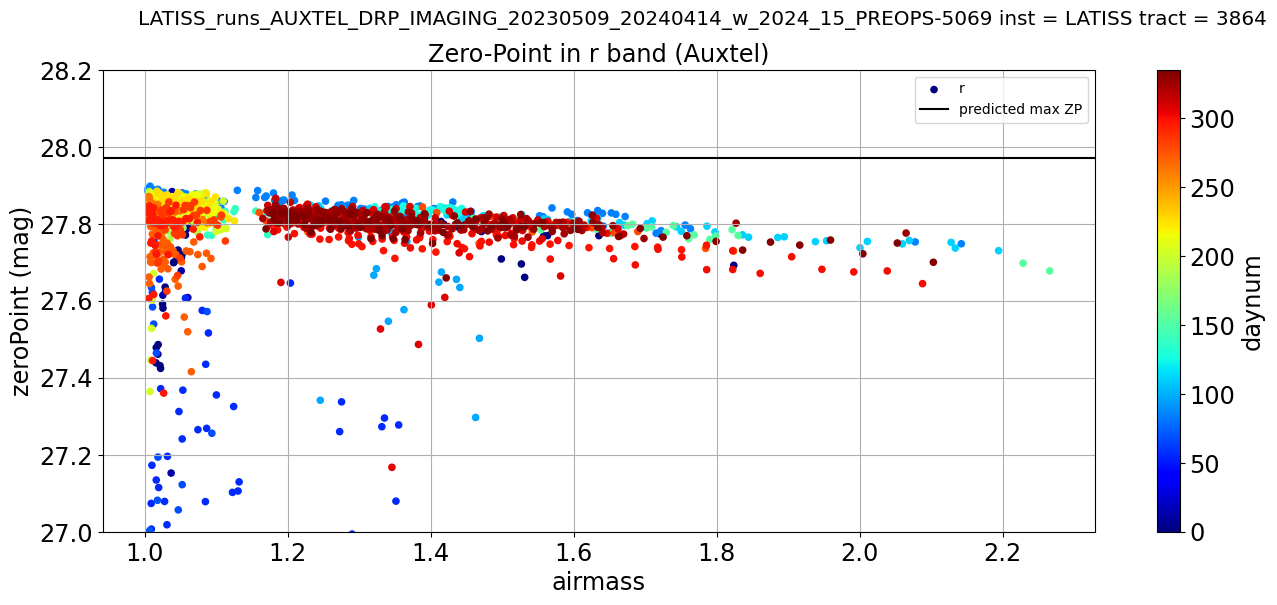

In [70]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=True)
title = "Zero-Point in r band (Auxtel)"
ccd_visit_table_r.plot.scatter(x="airmass",y="zeroPoint",marker="o",ax=ax,c="daynum",cmap="jet",grid=True,label="r",ylabel="zeroPoint (mag)")
ax.set_ylim(27.,28.2)
ax.set_title(title)
ax.axhline(zeropoint_mags["r"],c='k',label="predicted max ZP")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

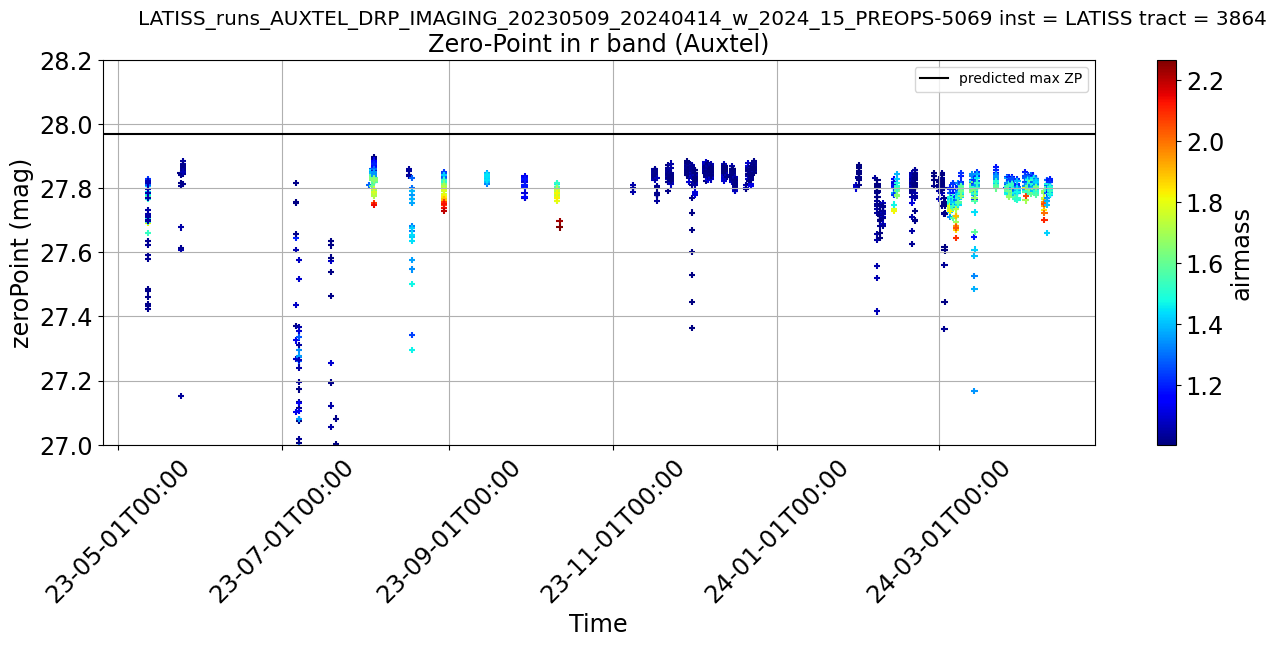

In [71]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = "Zero-Point in r band (Auxtel)"
ccd_visit_table_r.plot.scatter(x="Time",y="zeroPoint",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="zeroPoint (mag)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(27.,28.2)
ax.axhline(zeropoint_mags["r"],c='k',label="predicted max ZP")
ax.legend()
plt.suptitle(suptitle)

### Zero Point in i band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

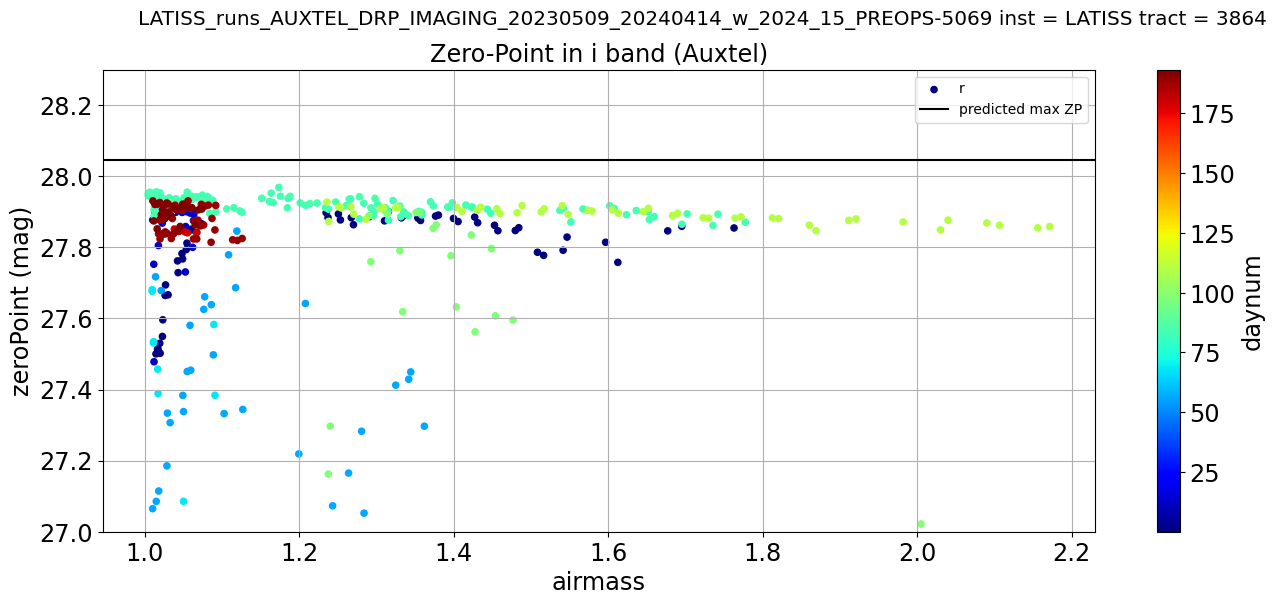

In [72]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=True)
title = "Zero-Point in i band (Auxtel)"
ccd_visit_table_i.plot.scatter(x="airmass",y="zeroPoint",marker="o",ax=ax,c="daynum",cmap="jet",grid=True,label="r",ylabel="zeroPoint (mag)")
ax.set_ylim(27.,28.3)
ax.set_title(title)
ax.axhline(zeropoint_mags["i"],c='k',label="predicted max ZP")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

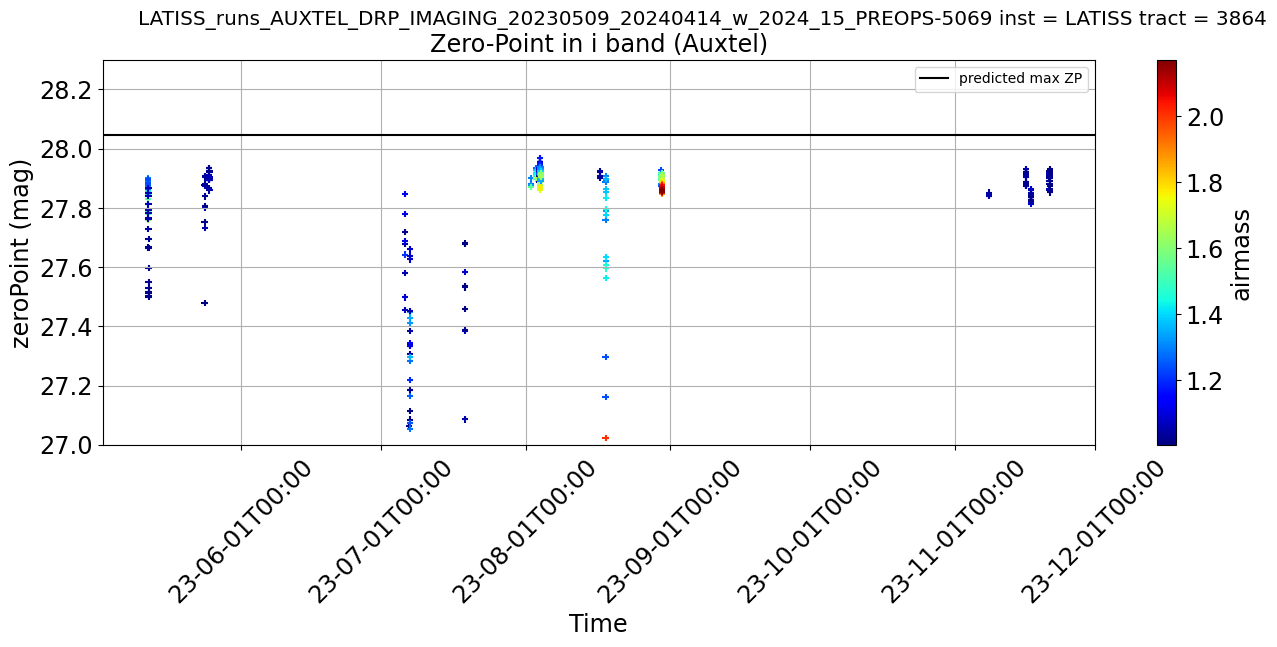

In [73]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = "Zero-Point in i band (Auxtel)"
ccd_visit_table_i.plot.scatter(x="Time",y="zeroPoint",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="zeroPoint (mag)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(27.,28.3)
ax.axhline(zeropoint_mags["i"],c='k',label="predicted max ZP")
ax.legend()
plt.suptitle(suptitle)

### Zero Point in z band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

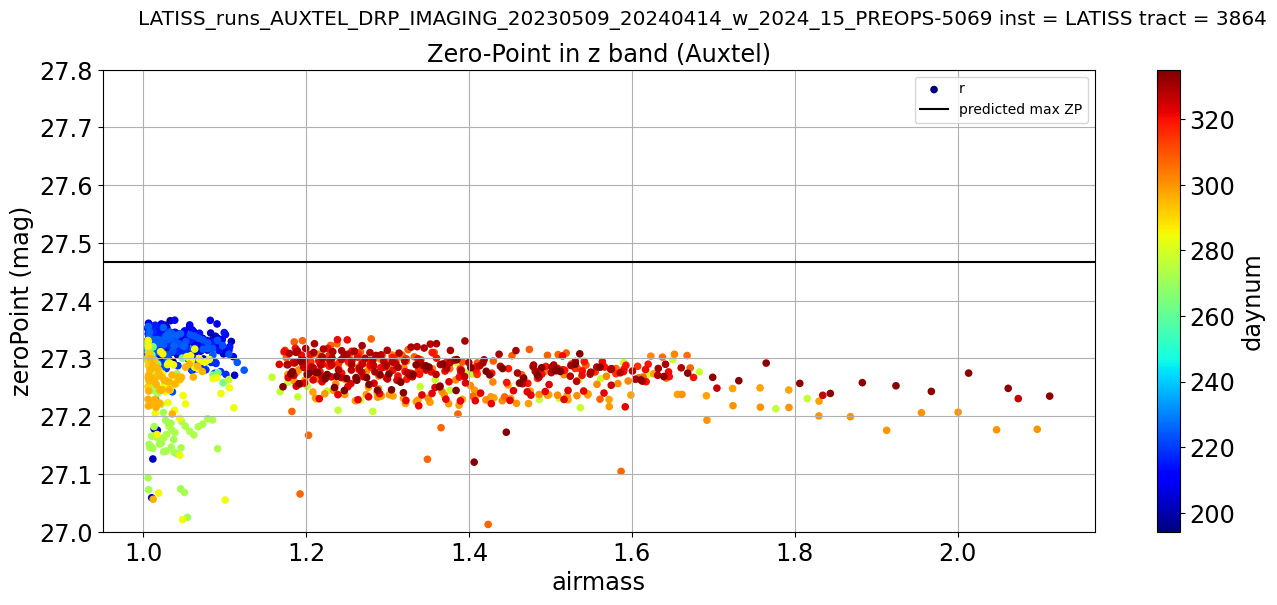

In [74]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=True)
title = "Zero-Point in z band (Auxtel)"
ccd_visit_table_z.plot.scatter(x="airmass",y="zeroPoint",marker="o",ax=ax,c="daynum",cmap="jet",grid=True,label="r",ylabel="zeroPoint (mag)")
ax.set_ylim(27.,27.8)
ax.set_title(title)
ax.axhline(zeropoint_mags["z"],c='k',label="predicted max ZP")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

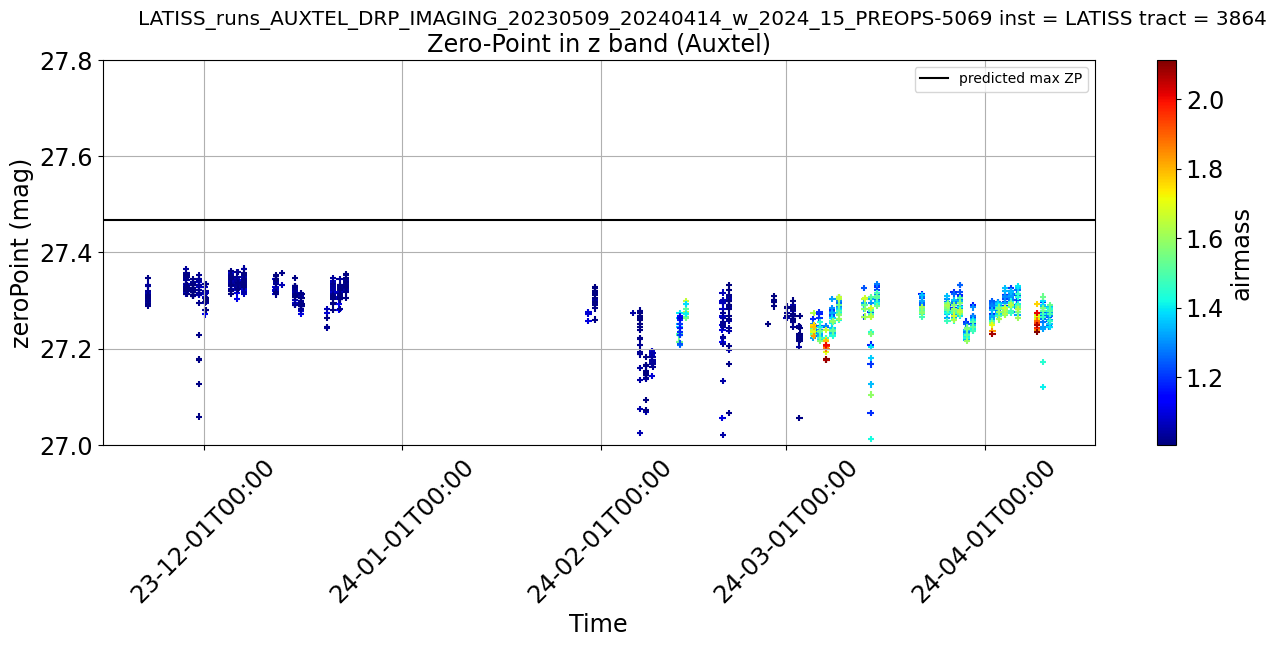

In [75]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = "Zero-Point in z band (Auxtel)"
ccd_visit_table_z.plot.scatter(x="Time",y="zeroPoint",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="zeroPoint (mag)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(27.,27.8)
ax.axhline(zeropoint_mags["z"],c='k',label="predicted max ZP")
ax.legend()
plt.suptitle(suptitle)

### Zero Point in y band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

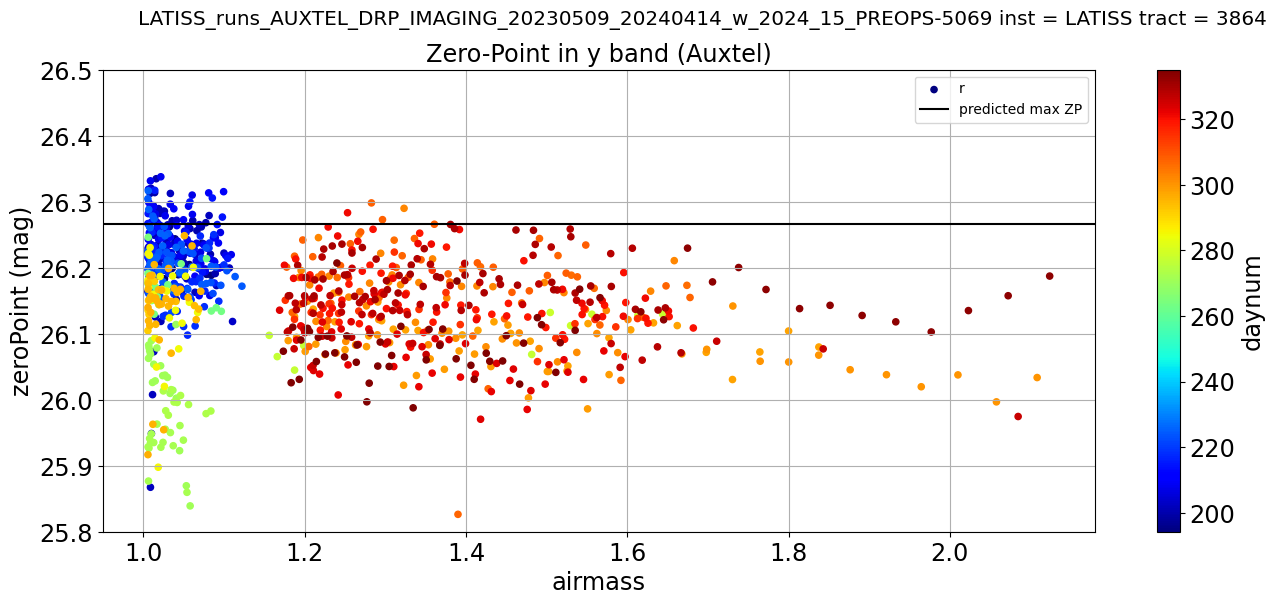

In [76]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=True)
title = "Zero-Point in y band (Auxtel)"
ccd_visit_table_y.plot.scatter(x="airmass",y="zeroPoint",marker="o",ax=ax,c="daynum",cmap="jet",grid=True,label="r",ylabel="zeroPoint (mag)")
ax.set_ylim(25.8,26.5)
ax.set_title(title)
ax.axhline(zeropoint_mags["y"],c='k',label="predicted max ZP")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

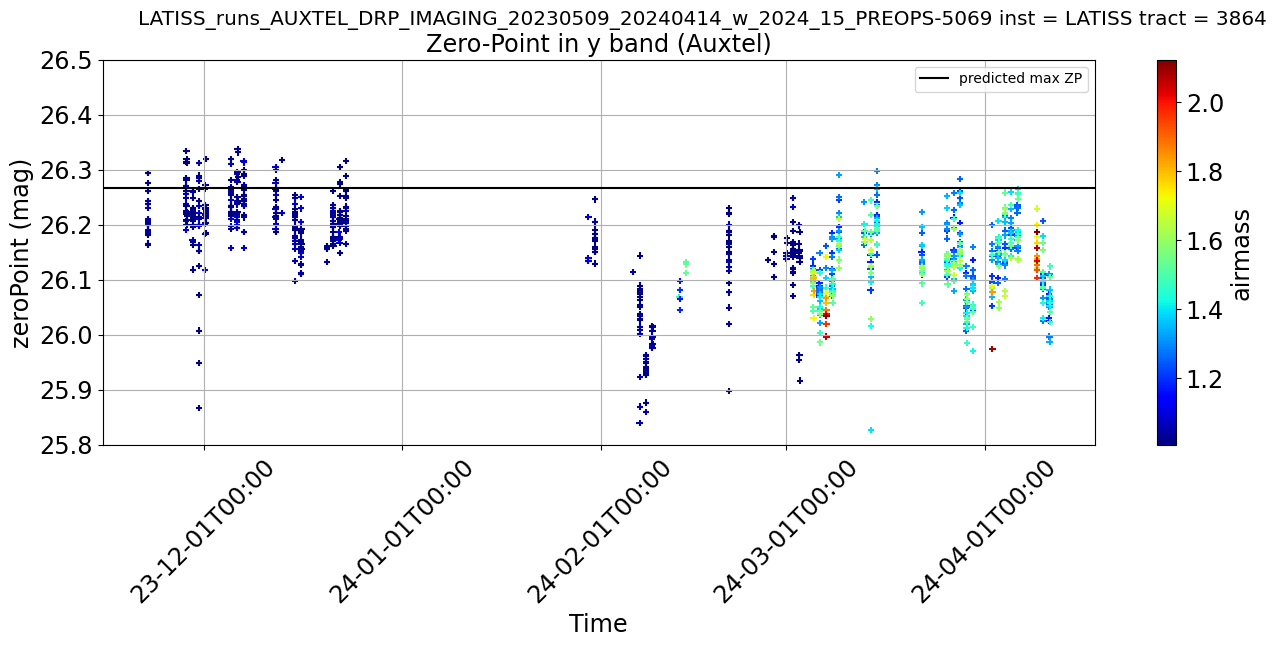

In [77]:
fig, ax = plt.subplots(1,1,figsize=(16,5),sharex=False)
title = "Zero-Point in y band (Auxtel)"
ccd_visit_table_y.plot.scatter(x="Time",y="zeroPoint",ax=ax,marker="+",c="airmass",cmap="jet",rot=45,ylabel="zeroPoint (mag)",title=title,grid=True)
ax.xaxis.set_major_formatter(date_form)
ax.set_ylim(25.8,26.5)
ax.axhline(zeropoint_mags["y"],c='k',label="predicted max ZP")
ax.legend()
plt.suptitle(suptitle)

## Zero-point and Sky Background

### PZ vs SkyBg in g band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

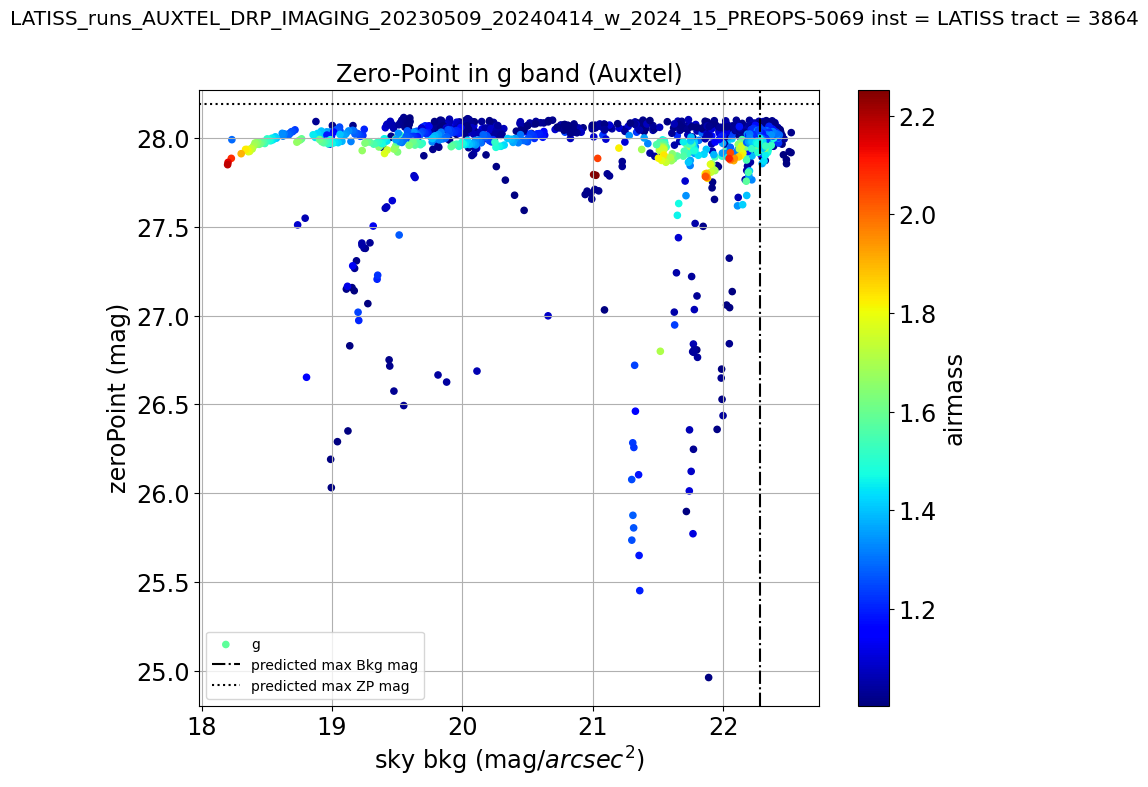

In [78]:
fig, ax = plt.subplots(1,1,figsize=(10,8),sharex=True)
title = "Zero-Point in g band (Auxtel)"
ccd_visit_table_g.plot.scatter(x="mb",y="zeroPoint",marker="o",ax=ax,c="airmass",cmap="jet",grid=True,label="g",xlabel="sky bkg (mag/$arcsec^2$)",ylabel="zeroPoint (mag)")
ax.axvline(darksky_mags["g"],c='k',ls="-.",label="predicted max Bkg mag")
ax.axhline(zeropoint_mags["g"],c='k',ls=":",label="predicted max ZP mag")
ax.set_title(title)
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

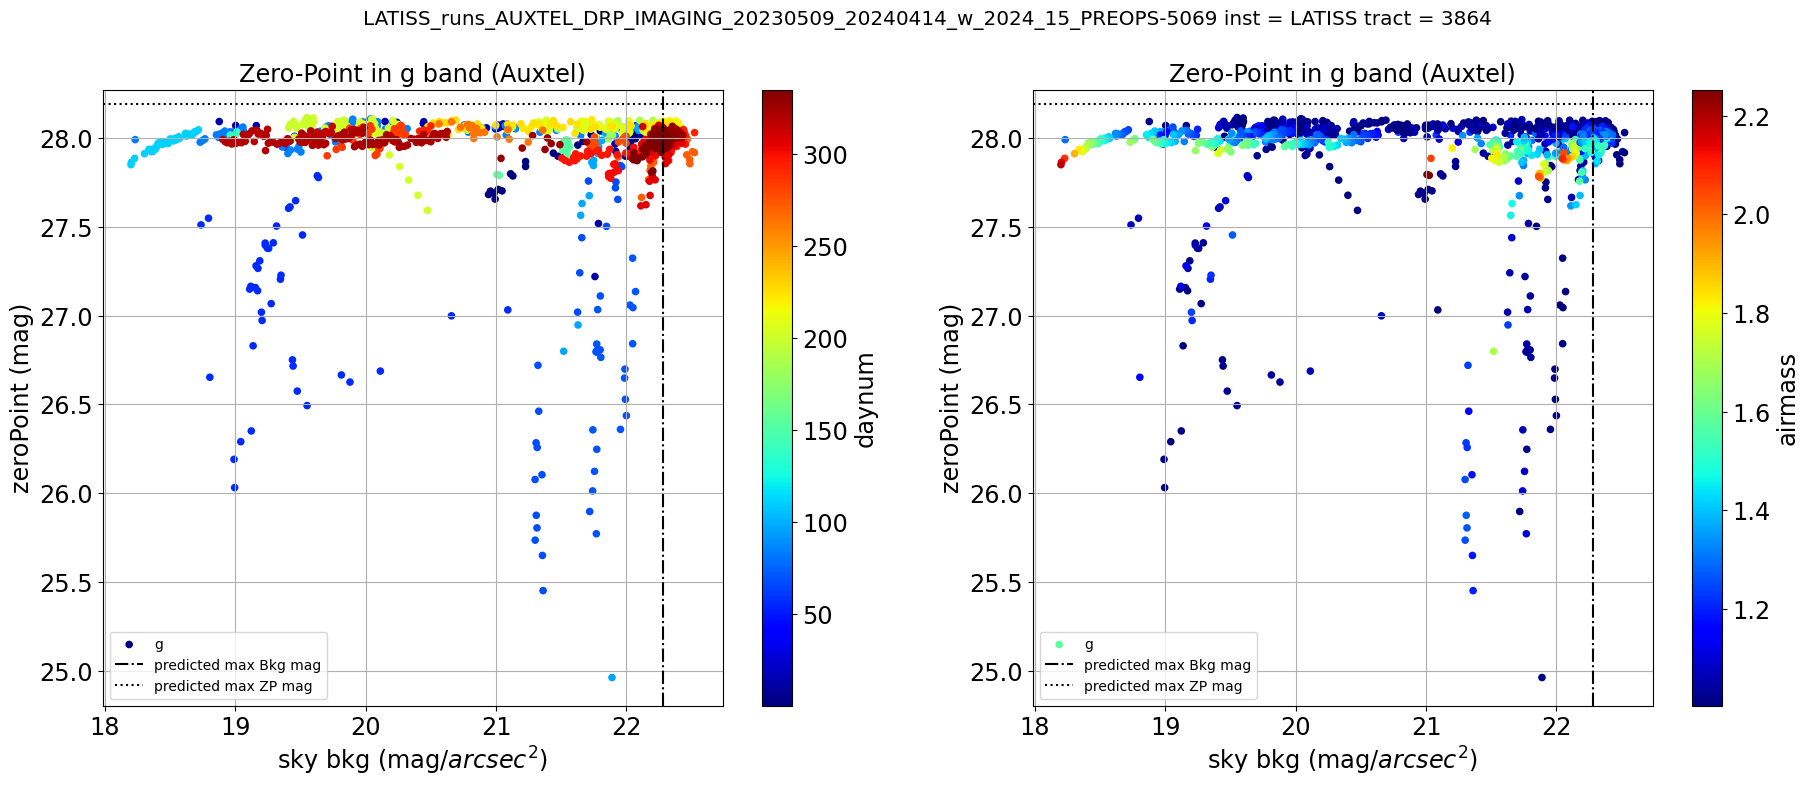

In [79]:
fig, axs = plt.subplots(1,2,figsize=(22,8),sharex=True)
ax1,ax2= axs.flat
title = "Zero-Point in g band (Auxtel)"
ccd_visit_table_g.plot.scatter(x="mb",y="zeroPoint",marker="o",ax=ax1,c="daynum",cmap="jet",grid=True,label="g",xlabel="sky bkg (mag/$arcsec^2$)",ylabel="zeroPoint (mag)")
ax1.set_title(title)
#ax1.set_aspect('equal')
ax1.axvline(darksky_mags["g"],c='k',ls="-.",label="predicted max Bkg mag")
ax1.axhline(zeropoint_mags["g"],c='k',ls=":",label="predicted max ZP mag")
ax1.legend()
ccd_visit_table_g.plot.scatter(x="mb",y="zeroPoint",marker="o",ax=ax2,c="airmass",cmap="jet",grid=True,label="g",xlabel="sky bkg (mag/$arcsec^2$)",ylabel="zeroPoint (mag)")
ax2.set_title(title)
#ax2.set_aspect('equal')
ax2.axvline(darksky_mags["g"],c='k',ls="-.",label="predicted max Bkg mag")
ax2.axhline(zeropoint_mags["g"],c='k',ls=":",label="predicted max ZP mag")
ax2.legend()
plt.suptitle(suptitle)

### PZ vs SkyBg in r band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

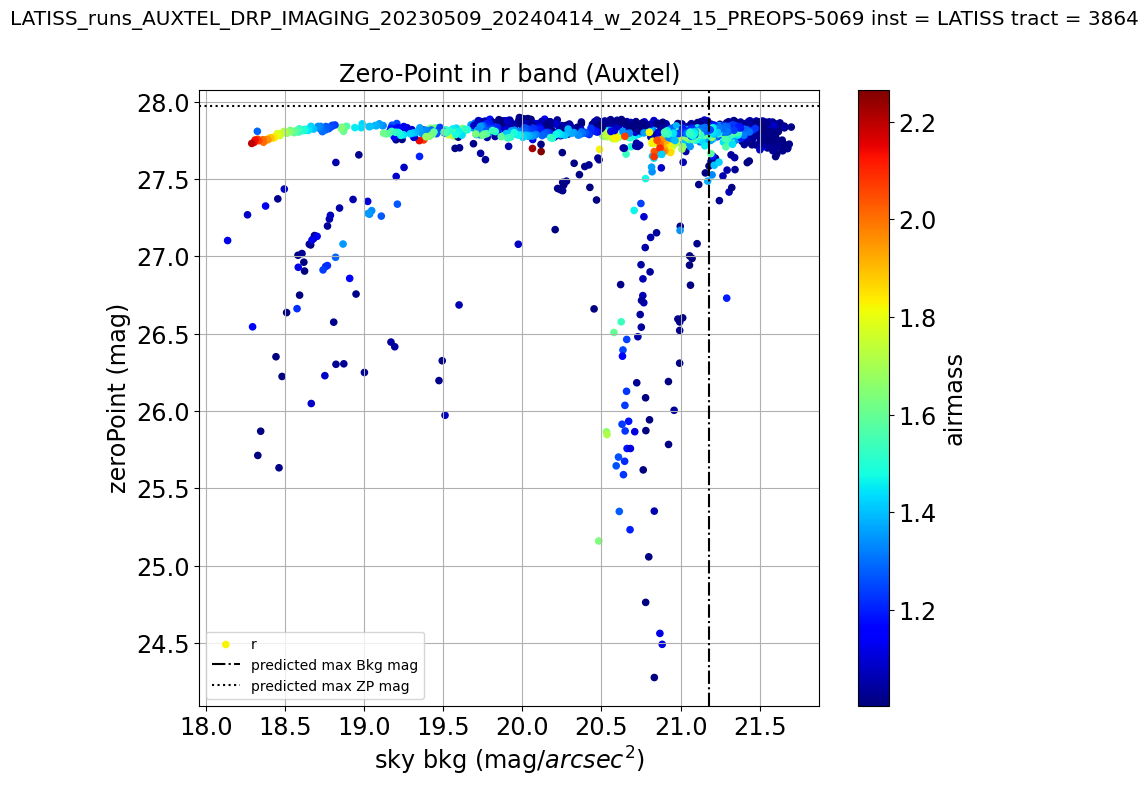

In [80]:
fig, ax = plt.subplots(1,1,figsize=(10,8),sharex=True)
title = "Zero-Point in r band (Auxtel)"
ccd_visit_table_r.plot.scatter(x="mb",y="zeroPoint",marker="o",ax=ax,c="airmass",cmap="jet",grid=True,label="r",xlabel="sky bkg (mag/$arcsec^2$)",ylabel="zeroPoint (mag)")
ax.set_title(title)
ax.axvline(darksky_mags["r"],c='k',ls="-.",label="predicted max Bkg mag")
ax.axhline(zeropoint_mags["r"],c='k',ls=":",label="predicted max ZP mag")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

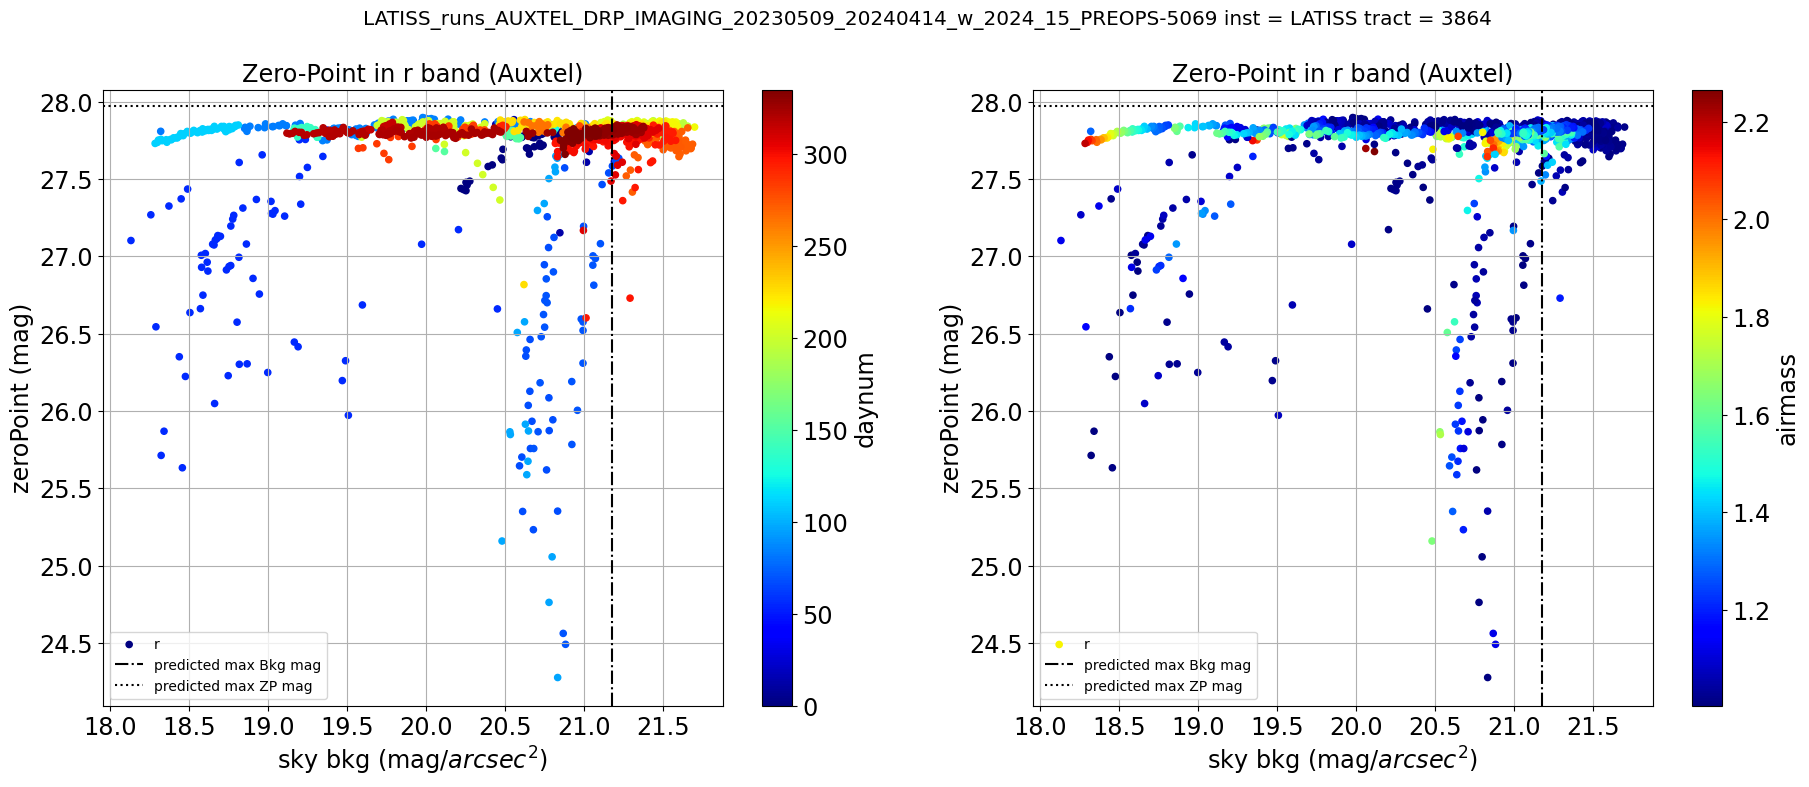

In [81]:
fig, axs = plt.subplots(1,2,figsize=(22,8),sharex=True)
ax1,ax2= axs.flat
title = "Zero-Point in r band (Auxtel)"
ccd_visit_table_r.plot.scatter(x="mb",y="zeroPoint",marker="o",ax=ax1,c="daynum",cmap="jet",grid=True,label="r",xlabel="sky bkg (mag/$arcsec^2$)",ylabel="zeroPoint (mag)")
ax1.set_title(title)
#ax1.set_aspect('equal')
ax1.axvline(darksky_mags["r"],c='k',ls="-.",label="predicted max Bkg mag")
ax1.axhline(zeropoint_mags["r"],c='k',ls=":",label="predicted max ZP mag")
ax1.legend()
ccd_visit_table_r.plot.scatter(x="mb",y="zeroPoint",marker="o",ax=ax2,c="airmass",cmap="jet",grid=True,label="r",xlabel="sky bkg (mag/$arcsec^2$)",ylabel="zeroPoint (mag)")
ax2.set_title(title)
#ax2.set_aspect('equal')
ax2.axvline(darksky_mags["r"],c='k',ls="-.",label="predicted max Bkg mag")
ax2.axhline(zeropoint_mags["r"],c='k',ls=":",label="predicted max ZP mag")
ax2.legend()
plt.suptitle(suptitle)

### PZ vs SkyBg in i band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

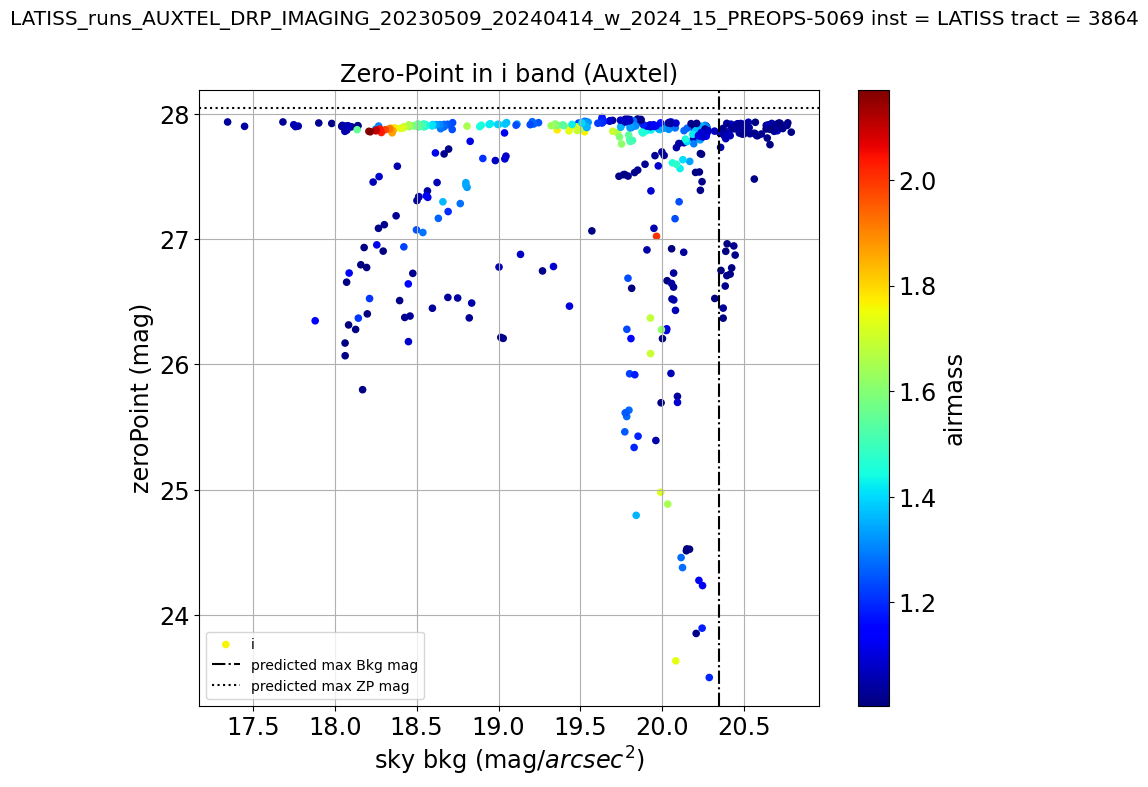

In [82]:
fig, ax = plt.subplots(1,1,figsize=(10,8),sharex=True)
title = "Zero-Point in i band (Auxtel)"
ccd_visit_table_i.plot.scatter(x="mb",y="zeroPoint",marker="o",ax=ax,c="airmass",cmap="jet",grid=True,label="i",xlabel="sky bkg (mag/$arcsec^2$)",ylabel="zeroPoint (mag)")
ax.set_title(title)
ax.axvline(darksky_mags["i"],c='k',ls="-.",label="predicted max Bkg mag")
ax.axhline(zeropoint_mags["i"],c='k',ls=":",label="predicted max ZP mag")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

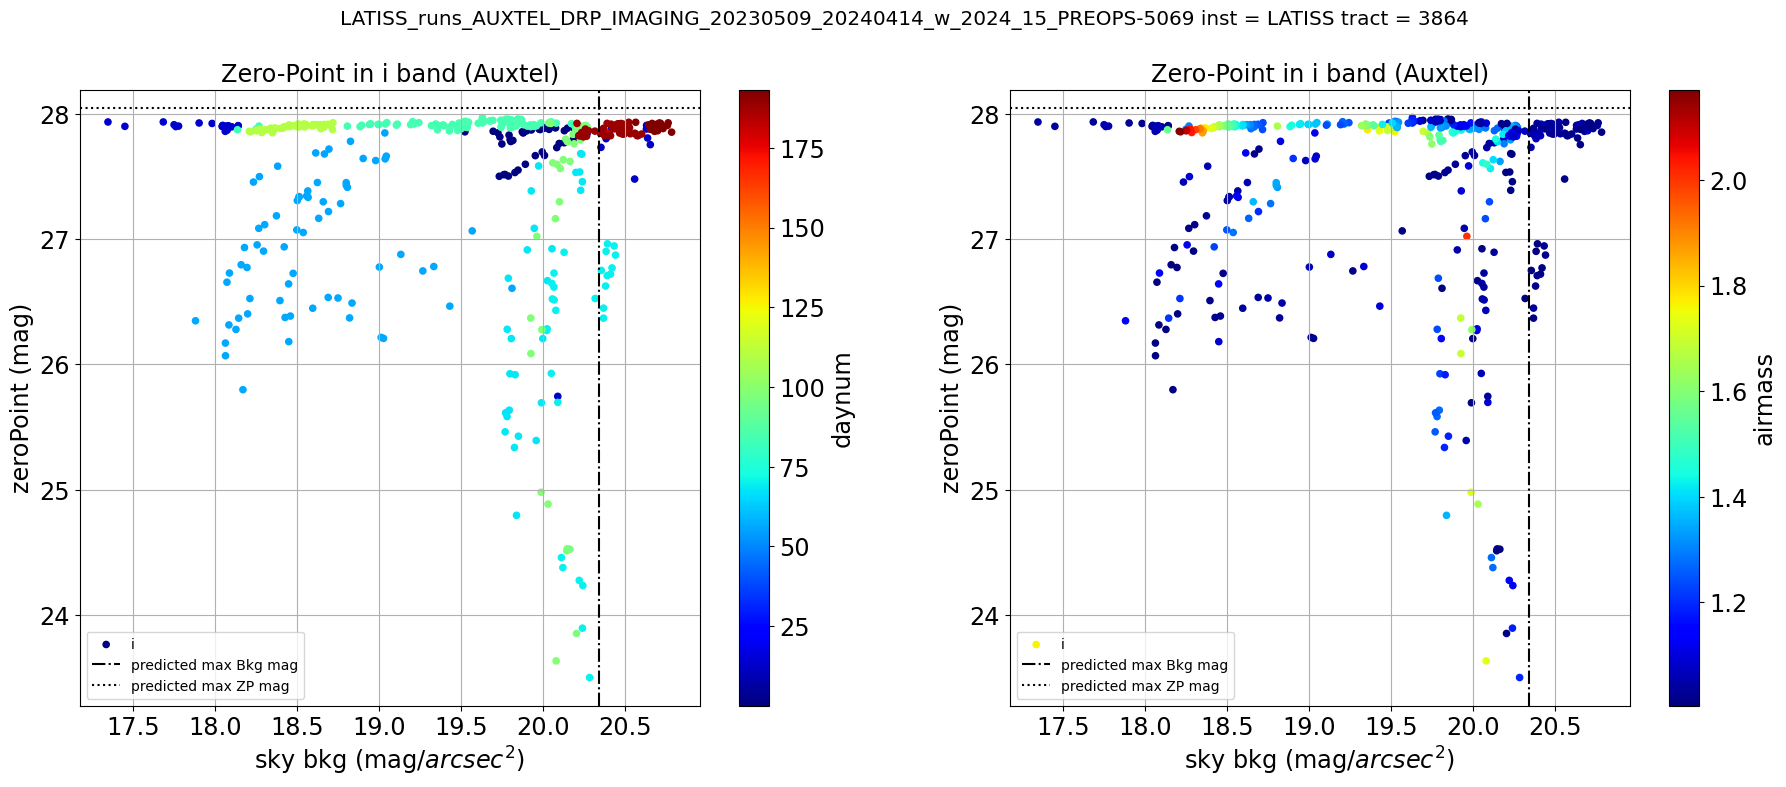

In [83]:
fig, axs = plt.subplots(1,2,figsize=(22,8),sharex=True)
ax1,ax2= axs.flat
title = "Zero-Point in i band (Auxtel)"
ccd_visit_table_i.plot.scatter(x="mb",y="zeroPoint",marker="o",ax=ax1,c="daynum",cmap="jet",grid=True,label="i",xlabel="sky bkg (mag/$arcsec^2$)",ylabel="zeroPoint (mag)")
ax1.set_title(title)
#ax1.set_aspect('equal')
ax1.axvline(darksky_mags["i"],c='k',ls="-.",label="predicted max Bkg mag")
ax1.axhline(zeropoint_mags["i"],c='k',ls=":",label="predicted max ZP mag")
ax1.legend()
ccd_visit_table_i.plot.scatter(x="mb",y="zeroPoint",marker="o",ax=ax2,c="airmass",cmap="jet",grid=True,label="i",xlabel="sky bkg (mag/$arcsec^2$)",ylabel="zeroPoint (mag)")
ax2.set_title(title)
#ax2.set_aspect('equal')
ax2.axvline(darksky_mags["i"],c='k',ls="-.",label="predicted max Bkg mag")
ax2.axhline(zeropoint_mags["i"],c='k',ls=":",label="predicted max ZP mag")
ax2.legend()
plt.suptitle(suptitle)

### PZ vs SkyBg in z band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

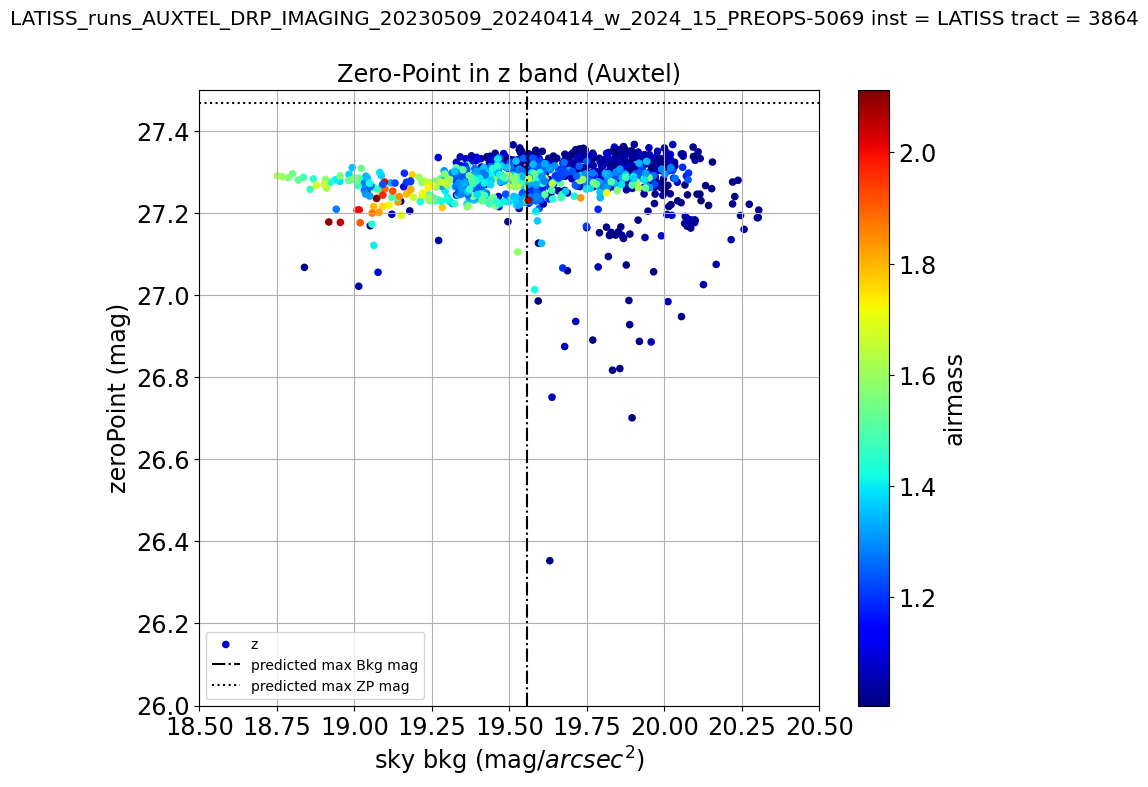

In [84]:
fig, ax = plt.subplots(1,1,figsize=(10,8),sharex=True)
title = "Zero-Point in z band (Auxtel)"
ccd_visit_table_z.plot.scatter(x="mb",y="zeroPoint",marker="o",ax=ax,c="airmass",cmap="jet",grid=True,label="z",xlabel="sky bkg (mag/$arcsec^2$)",ylabel="zeroPoint (mag)")
ax.set_title(title)
ax.axvline(darksky_mags["z"],c='k',ls="-.",label="predicted max Bkg mag")
ax.axhline(zeropoint_mags["z"],c='k',ls=":",label="predicted max ZP mag")
ax.legend()
ax.set_xlim(18.5,20.5)
ax.set_ylim(26,27.5)
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

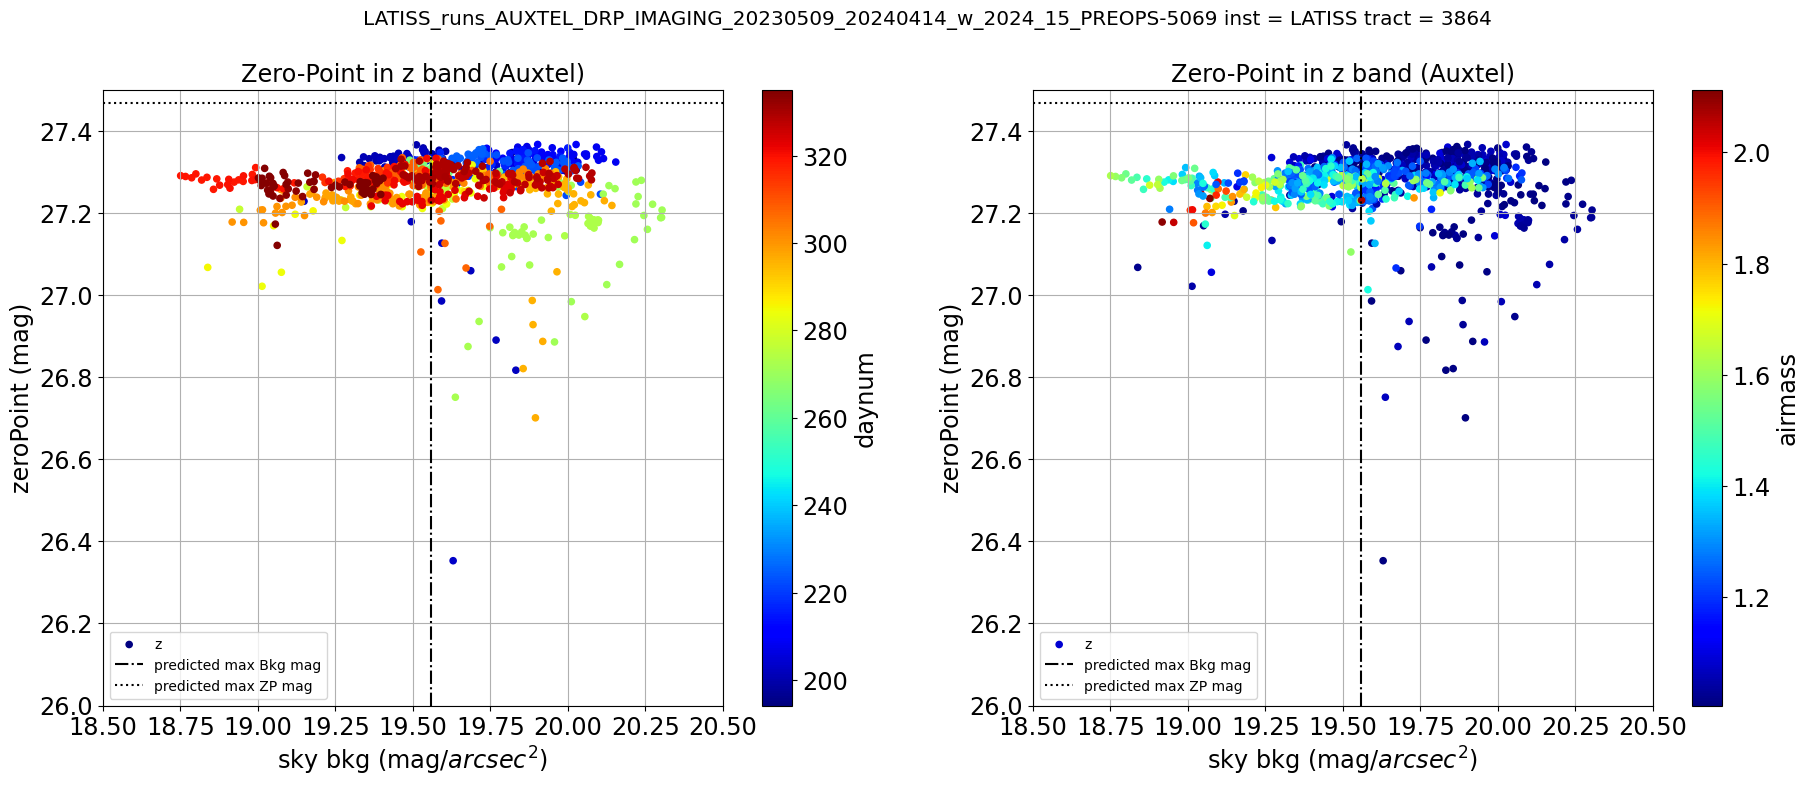

In [85]:
fig, axs = plt.subplots(1,2,figsize=(22,8),sharex=True)
ax1,ax2= axs.flat
title = "Zero-Point in z band (Auxtel)"
ccd_visit_table_z.plot.scatter(x="mb",y="zeroPoint",marker="o",ax=ax1,c="daynum",cmap="jet",grid=True,label="z",xlabel="sky bkg (mag/$arcsec^2$)",ylabel="zeroPoint (mag)")
ax1.set_title(title)
#ax1.set_aspect('equal')
ax1.set_xlim(18.5,20.5)
ax1.set_ylim(26,27.5)
ax1.axvline(darksky_mags["z"],c='k',ls="-.",label="predicted max Bkg mag")
ax1.axhline(zeropoint_mags["z"],c='k',ls=":",label="predicted max ZP mag")
ax1.legend()
ccd_visit_table_z.plot.scatter(x="mb",y="zeroPoint",marker="o",ax=ax2,c="airmass",cmap="jet",grid=True,label="z",xlabel="sky bkg (mag/$arcsec^2$)",ylabel="zeroPoint (mag)")
ax2.set_title(title)
#ax2.set_aspect('equal')
ax2.axvline(darksky_mags["z"],c='k',ls="-.",label="predicted max Bkg mag")
ax2.axhline(zeropoint_mags["z"],c='k',ls=":",label="predicted max ZP mag")
ax2.legend()
ax2.set_xlim(18.5,20.5)
ax2.set_ylim(26,27.5)
plt.suptitle(suptitle)

### PZ vs SkyBg in y band

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

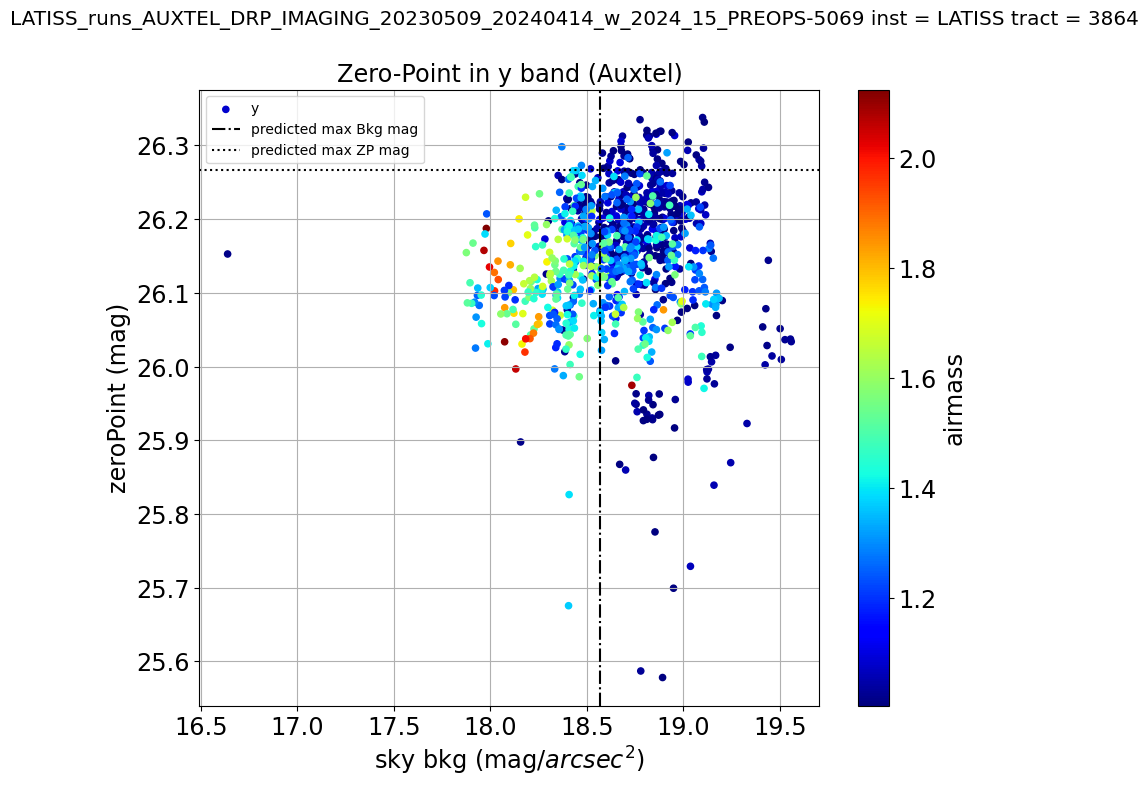

In [86]:
fig, ax = plt.subplots(1,1,figsize=(10,8),sharex=True)
title = "Zero-Point in y band (Auxtel)"
ccd_visit_table_y.plot.scatter(x="mb",y="zeroPoint",marker="o",ax=ax,c="airmass",cmap="jet",grid=True,label="y",xlabel="sky bkg (mag/$arcsec^2$)",ylabel="zeroPoint (mag)")
ax.set_title(title)
ax.axvline(darksky_mags["y"],c='k',ls="-.",label="predicted max Bkg mag")
ax.axhline(zeropoint_mags["y"],c='k',ls=":",label="predicted max ZP mag")
ax.legend()
plt.suptitle(suptitle)

Text(0.5, 0.98, 'LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240414_w_2024_15_PREOPS-5069 inst = LATISS tract = 3864')

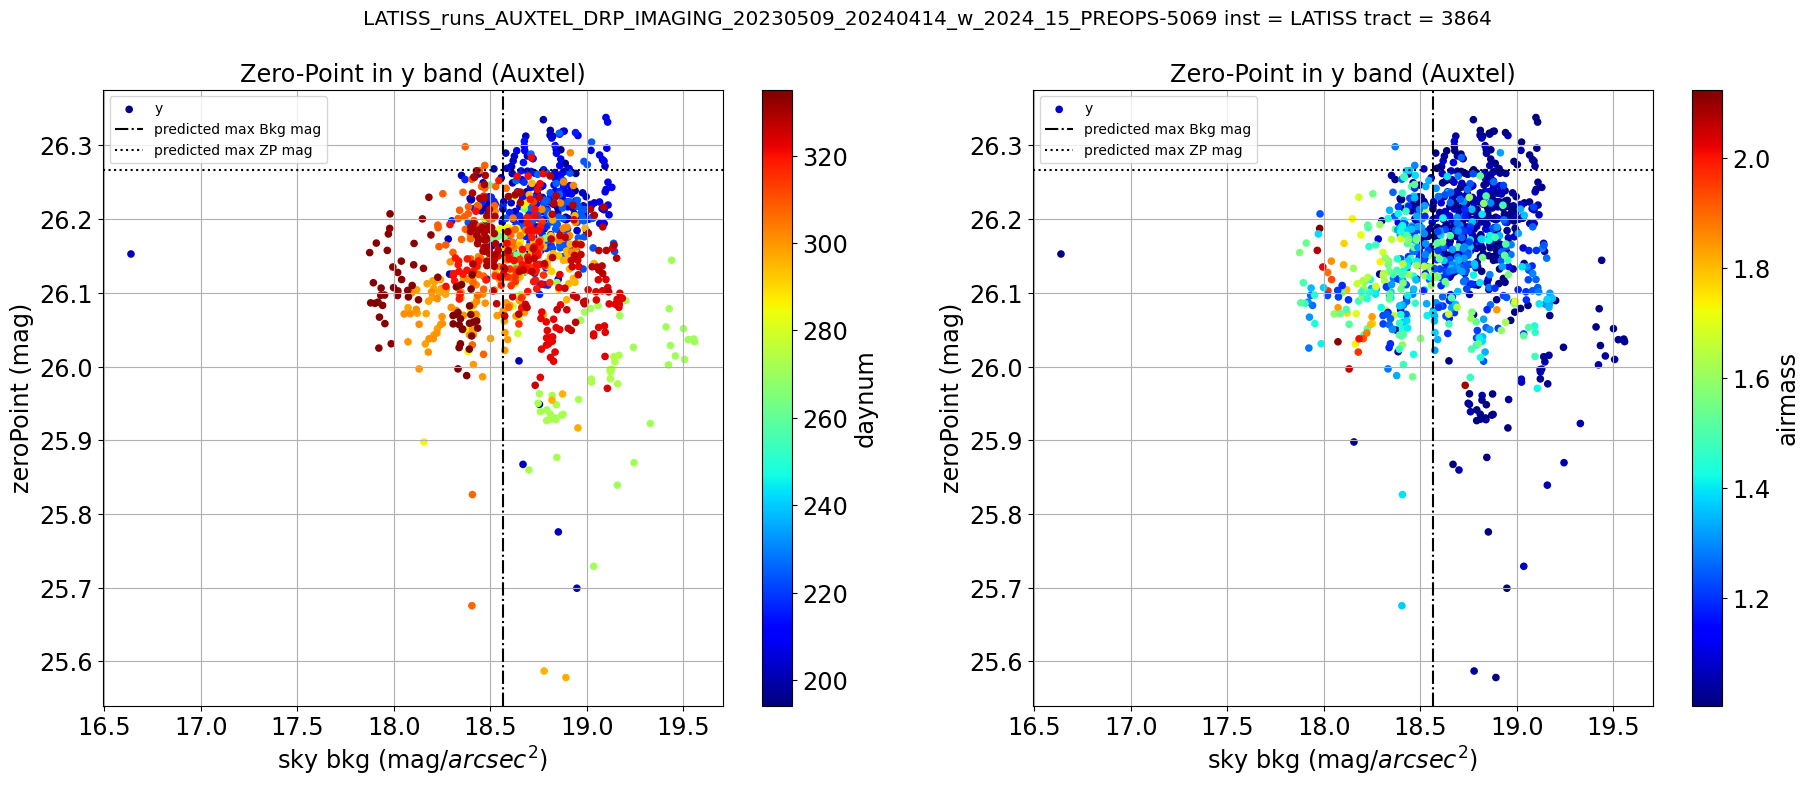

In [87]:
fig, axs = plt.subplots(1,2,figsize=(22,8),sharex=True)
ax1,ax2= axs.flat
title = "Zero-Point in y band (Auxtel)"
ccd_visit_table_y.plot.scatter(x="mb",y="zeroPoint",marker="o",ax=ax1,c="daynum",cmap="jet",grid=True,label="y",xlabel="sky bkg (mag/$arcsec^2$)",ylabel="zeroPoint (mag)")
ax1.set_title(title)
#ax1.set_aspect('equal')
ax1.axvline(darksky_mags["y"],c='k',ls="-.",label="predicted max Bkg mag")
ax1.axhline(zeropoint_mags["y"],c='k',ls=":",label="predicted max ZP mag")
ax1.legend()
ccd_visit_table_y.plot.scatter(x="mb",y="zeroPoint",marker="o",ax=ax2,c="airmass",cmap="jet",grid=True,label="y",xlabel="sky bkg (mag/$arcsec^2$)",ylabel="zeroPoint (mag)")
ax2.set_title(title)
ax2.axvline(darksky_mags["y"],c='k',ls="-.",label="predicted max Bkg mag")
ax2.axhline(zeropoint_mags["y"],c='k',ls=":",label="predicted max ZP mag")
#ax2.set_aspect('equal')
ax2.legend()

plt.suptitle(suptitle)

## Selection of visits 

In [88]:
ccd_visit_table_g

visitId   physical_filter band          ra        dec  \
ccdVisitId                                                                 
40919700992  2023051100278  SDSSg_65mm~empty    g  239.998846 -24.040317   
40919701760  2023051100281  SDSSg_65mm~empty    g  240.024082 -24.046589   
40919702528  2023051100284  SDSSg_65mm~empty    g  240.051539 -24.048022   
40919703296  2023051100287  SDSSg_65mm~empty    g  240.064265 -24.050210   
40919704064  2023051100290  SDSSg_65mm~empty    g  239.951120 -24.025228   
...                    ...               ...  ...         ...        ...   
43729934848  2024041000474  SDSSg_65mm~empty    g  122.494932 -36.170500   
43729935872  2024041000478  SDSSg_65mm~empty    g  122.513390 -36.170445   
43729936896  2024041000482  SDSSg_65mm~empty    g  122.531812 -36.170390   
43729937920  2024041000486  SDSSg_65mm~empty    g  122.550197 -36.170454   
43729938944  2024041000490  SDSSg_65mm~empty    g  122.568634 -36.170416   

             zenithDistance  zeroPoint  psfSigma     skyBg  skyNoise  \
ccdVisitId                                                             
40919700992       50.736954  27.935040  7.404854  3.719091  7.444159   
40919701760       49.896904  27.946257  7.433076  3.670910  7.467782   
40919702528       49.398579  27.894304  6.930718  3.674170  7.461042   
40919703296       48.905041  27.898705  7.174919  3.802481  7.482316   
40919704064       48.317284  27.899073  7.477948  3.832790  7.481977   
...                     ...        ...       ...       ...       ...   
43729934848       45.752666  27.982452  7.620708  2.995070  7.512336   
43729935872       46.538616  27.974169  7.861673  3.007432  7.495173   
43729936896       47.323380  27.967152  8.201857  2.976068  7.509158   
43729937920       48.105812  27.920027  8.539274  2.971344  7.505595   
43729938944       48.890800  27.940567  7.590302  3.106054  7.474746   

             astromOffsetMean  astromOffsetStd  nPsfStar  \
ccdVisitId                                                 
40919700992          0.024243         0.012858        17   
40919701760          0.021952         0.013686        17   
40919702528          0.026651         0.014490        27   
40919703296          0.022884         0.011841        19   
40919704064          0.022186         0.013076        14   
...                       ...              ...       ...   
43729934848          0.026598         0.015817        41   
43729935872          0.024282         0.014569        33   
43729936896          0.023551         0.015190        23   
43729937920          0.025723         0.016424        23   
43729938944          0.023803         0.013601        24   

             psfStarDeltaE1Median  psfStarDeltaE2Median  \
ccdVisitId                                                
40919700992              0.003969             -0.003400   
40919701760              0.001344             -0.000063   
40919702528             -0.001941              0.003225   
40919703296             -0.002015             -0.008045   
40919704064              0.012048             -0.000654   
...                           ...                   ...   
43729934848              0.007104             -0.005513   
43729935872             -0.014123              0.001596   
43729936896             -0.002819              0.010882   
43729937920             -0.002806              0.001302   
43729938944             -0.001470             -0.011347   

             psfStarDeltaE1Scatter  psfStarDeltaE2Scatter  \
ccdVisitId                                                  
40919700992               0.008414               0.016104   
40919701760               0.019548               0.035684   
40919702528               0.020636               0.030294   
40919703296               0.011366               0.012915   
40919704064               0.012450               0.047349   
...                            ...                    ...   
43729934848               0.027217               0.01345

In [89]:
DAYNUMMIN=200
DAYNUMMAX=250
ZPMIN=27.5
ZPMAX=28
MBMIN=20
MBMAX=21

In [90]:
cut1 = (ccd_visit_table_g["daynum"] > DAYNUMMIN)  & (ccd_visit_table_g["daynum"] < DAYNUMMAX)
cut2 = (ccd_visit_table_g["zeroPoint"] > ZPMIN)  & (ccd_visit_table_g["zeroPoint"] < ZPMAX)
cut3 = (ccd_visit_table_g["mb"] > MBMIN)  & (ccd_visit_table_g["mb"] < MBMAX)
cut = cut1 & cut2 & cut3

In [91]:
ccdvisit_selected = ccd_visit_table_g[cut]

In [92]:
ccdvisit_selected

visitId   physical_filter band          ra        dec  \
ccdVisitId                                                                 
42614285568  2023112900613  SDSSg_65mm~empty    g  122.504458 -36.128511   
42614286592  2023112900617  SDSSg_65mm~empty    g  122.522607 -36.128485   
42614287616  2023112900621  SDSSg_65mm~empty    g  122.540279 -36.128302   
42614288640  2023112900625  SDSSg_65mm~empty    g  122.558387 -36.128219   
42614289664  2023112900629  SDSSg_65mm~empty    g  122.429545 -36.206799   
42614290688  2023112900633  SDSSg_65mm~empty    g  122.447779 -36.206725   

             zenithDistance  zeroPoint  psfSigma      skyBg  skyNoise  \
ccdVisitId                                                              
42614285568        9.528257  27.945932  5.490109  22.962042  8.504101   
42614286592        8.931370  27.905458  5.092951  20.295702  8.357081   
42614287616        8.367973  27.839678  4.988669  18.873140  8.293358   
42614288640        7.841112  27.763521  6.293645  17.706266  8.229728   
42614289664        7.349023  27.678408  5.909456  16.589357  8.206800   
42614290688        6.935110  27.593149  6.059192  15.506880  8.169852   

             astromOffsetMean  astromOffsetStd  nPsfStar  \
ccdVisitId                                                 
42614285568          0.012863         0.007372        44   
42614286592          0.013885         0.007331        64   
42614287616          0.013637         0.007563        42   
42614288640          0.014566         0.007667        31   
42614289664          0.012974         0.007197        34   
42614290688          0.017594         0.009281        27   

             psfStarDeltaE1Median  psfStarDeltaE2Median  \
ccdVisitId                                                
42614285568              0.009244             -0.001301   
42614286592             -0.005833             -0.005151   
42614287616             -0.002851             -0.007532   
42614288640              0.004250              0.006386   
42614289664              0.005231             -0.004110   
42614290688             -0.005304             -0.003208   

             psfStarDeltaE1Scatter  psfStarDeltaE2Scatter  \
ccdVisitId                                                  
42614285568               0.019271               0.028040   
42614286592               0.019880               0.024156   
42614287616               0.022741               0.028053   
42614288640               0.021792               0.025370   
42614289664               0.020720               0.015660   
42614290688               0.027794               0.017002   

             psfStarDeltaSizeMedian  psfStarDeltaSizeScatter  \
ccdVisitId                                                     
42614285568                0.006863                 0.059565   
42614286592                0.011905                 0.050760   
42614287616               -0.021139                 0.026996   
42614288640               -0.038899                 0.052474   
42614289664               -0.025266                 0.051568   
42614290688               -0.010453                 0.075142   

             psfStarScaledDeltaSizeScatter  psfTraceRadiusDelta  \
ccdVisitId                                                        
42614285568                       0.010787             0.429725   
42614286592                       0.009954             0.445141   
42614287616                       0.005442             0.608468   
42614288640                       0.008312             0.586116   
42614289664                       0.008724             0.380183   
42614290688                       0.012469             0.447012   

             maxDistToNearestPsf   effTime  effTimePsfSigmaScale  \
ccdVisitId                                                         
42614285568          1986.258301  0.328529              0.033177   
42614286592          1254.716431  0.400889              0.038553   
42614287616          1581.655029  0.398042              0.04

In [93]:
ccdvisit_selected["visitId"]

ccdVisitId
42614285568    2023112900613
42614286592    2023112900617
42614287616    2023112900621
42614288640    2023112900625
42614289664    2023112900629
42614290688    2023112900633
Name: visitId, dtype: int64